In [ ]:
%pip install -q flwr[simulation] flwr-datasets[vision]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
%pip install -U "flwr[simulation]"

  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/26.4 MB ? eta -:--:--
   - -------------------------------------- 1.0/26.4 MB 10.1 MB/s eta 0:00:03
   --- ------------------------------------ 2.1/26.4 MB 4.7 MB/s eta 0:00:06
   ----- ---------------------------------- 3.7/26.4 MB 5.7 MB/s eta 0:00:04
   -------- ------------------------------- 5.8/26.4 MB 6.9 MB/s eta 0:00:03
   ----------- ---------------------------- 7.3/26.4 MB 7.3 MB/s eta 0:00:03
   ------------- -------------------------- 8.7/26.4 MB 6.8 MB/s eta 0:00:03
   ---------------- ----------------------- 11.0/26.4 MB 7.4 MB/s eta 0:00:03
   -------------------- ------------------- 13.4/26.4 MB 7.8 MB/s eta 0:00:02
   ----------------------- ---------------- 15.7/26.4 MB 8.2 MB/s eta 0:00:02
   --------------------------- ------------ 18.1/26.4 MB 8.5 MB/s eta 0:00:01
 


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from collections import OrderedDict
from typing import List, Tuple

import copy
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-24 13:22:25,979	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Training on cuda
Flower 1.15.2 / PyTorch 2.6.0+cu126


## Initialising Dataset - ISIC2019

In [2]:
class IsicDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure RGB format
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        # Return image, label, and image name (without path and extension)
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        return image, label, image_name

def create_iid_partitions(original_df, test_size=0.2, seed=8):
    """
    Create IID partitions while preserving the original center sizes and
    performing an 80-20 train-test split within each center.
    
    Returns:
        iid_df: A DataFrame containing all rows from original_df with two new columns:
                - 'center': the new IID center assignment (0, 1, 2, …)
                - 'split': either "train" or "test" (80-20 split per center)
    """
    # 1. Determine original center sizes from the non-IID setup.
    #    This preserves the total number of samples per center.
    center_counts = original_df["center"].value_counts().sort_index()
    original_center_sizes = center_counts.values  # array of sizes for each center
    
    # 2. Create an IID ordering of indices for the entire dataset in a stratified way.
    np.random.seed(seed)
    iid_indices = np.random.permutation(len(original_df))
    
    # 3. Partition the indices into groups with the same sizes as the original centers.
    partitions = []
    start = 0
    for size in original_center_sizes:
        end = start + size
        partitions.append(iid_indices[start:end])
        start = end
    
    # 4. Create a copy of the DataFrame and add/override the 'center' and 'split' columns.
    iid_df = original_df.copy()
    iid_df["center"] = -1  # New center assignments.
    iid_df["fold"] = ""   # Will mark rows as "train" or "test".
    
    # 5. For each partition (center), assign the new center ID and perform a stratified split.
    for center_id, part in enumerate(partitions):
        iid_df.loc[part, "center"] = center_id
        
        # Extract the subset for this center.
        center_data = iid_df.loc[part]
        center_indices = center_data.index
        center_targets = center_data["target"]
        
        # Perform stratified train-test split for this center.
        train_idx, test_idx = train_test_split(
            center_indices,
            test_size=test_size,
            stratify=center_targets,
            random_state=seed
        )
        
        iid_df.loc[train_idx, "fold"] = "train"
        iid_df.loc[test_idx, "fold"] = "test"
    
    return iid_df

In [3]:
# Load the dataset information
split_file = os.path.join("isic_dataset", "train_test_split")
df = pd.read_csv(split_file)

# Use only training data for calculating statistics
train_data = df[df["fold"] == "train"]

# Function to get the correct image path
def get_image_path(image_name):
    downsampled_path = os.path.join("isic_dataset", "ISIC_2019_Training_Input_preprocessed", f"{image_name}_downsampled.jpg")
    if os.path.exists(downsampled_path):
        return downsampled_path
    original_path = os.path.join("isic_dataset", "ISIC_2019_Training_Input_preprocessed", f"{image_name}.jpg")
    if os.path.exists(original_path):
        return original_path
    raise FileNotFoundError(f"Image not found: {image_name}")

# Get image paths
image_paths = [get_image_path(image_name) for image_name in train_data["image"]]

# Basic transform for resizing consistently
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# Create dataset and loader
dataset = IsicDataset(image_paths, [0] * len(image_paths), transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Calculate mean and std
# First pass: compute mean
pixel_sum = torch.zeros(3)
pixel_count = 0

print("Calculating mean...")
for images, _, _ in tqdm(loader):
    batch_pixels = images.size(0) * images.size(2) * images.size(3)
    pixel_sum += torch.sum(images, dim=[0, 2, 3])
    pixel_count += batch_pixels

mean = pixel_sum / pixel_count

# Second pass: compute std
variance_sum = torch.zeros(3)

print("Calculating standard deviation...")
for images, _, _ in tqdm(loader):
    diff = (images - mean.view(1, 3, 1, 1)) ** 2
    variance_sum += torch.sum(diff, dim=[0, 2, 3])

std = torch.sqrt(variance_sum / pixel_count)

mean_list = mean.tolist()
std_list = std.tolist()

print(f"Dataset statistics:")
print(f"Mean: {mean_list}")
print(f"Std: {std_list}")


Calculating mean...


100%|██████████| 291/291 [00:42<00:00,  6.81it/s]


Calculating standard deviation...


100%|██████████| 291/291 [00:32<00:00,  9.00it/s]

Dataset statistics:
Mean: [0.5895478129386902, 0.5659915804862976, 0.5565221309661865]
Std: [0.19946560263633728, 0.21518221497535706, 0.22123825550079346]


In [4]:

def load_dataset(center_id, data_dir="isic_dataset", batch_size=64, iid = False):
    # Load the train_test_split file
    split_file = os.path.join(data_dir, "train_test_split")
    
    if iid:
        # Load pre-generated IID partitions (cache this)
        iid_file = os.path.join(data_dir, "iid_partitions")
        if not os.path.exists(iid_file):
            original_df = pd.read_csv(split_file)
            iid_df = create_iid_partitions(original_df)
            iid_df.to_csv(iid_file)
            
        df = pd.read_csv(iid_file)
    else:
        df = pd.read_csv(split_file)
    
    # Filter data for the given center_id
    center_data = df[df["center"] == center_id]
    
    # Split into train and test based on the 'fold' column
    train_data = center_data[center_data["fold"] == "train"]
    test_data = center_data[center_data["fold"] == "test"]
    
    # Function to get the correct image path
    def get_image_path(image_name):
        # Try with "_downsampled" suffix first
        downsampled_path = os.path.join(data_dir, "ISIC_2019_Training_Input_preprocessed", f"{image_name}_downsampled.jpg")
        if os.path.exists(downsampled_path):
            return downsampled_path
        # If not found, try without the suffix
        original_path = os.path.join(data_dir, "ISIC_2019_Training_Input_preprocessed", f"{image_name}.jpg")
        if os.path.exists(original_path):
            return original_path
        # If neither exists, raise an error
        raise FileNotFoundError(f"Image not found: {image_name}")
    
    # Get image paths and labels
    train_image_paths = [get_image_path(image_name) for image_name in train_data["image"]]
    test_image_paths = [get_image_path(image_name) for image_name in test_data["image"]]
    
    train_labels = train_data["target"].values
    test_labels = test_data["target"].values
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_list,std=std_list)
    ])
    
    # Create datasets
    train_dataset = IsicDataset(train_image_paths, train_labels, transform=transform)
    test_dataset = IsicDataset(test_image_paths, test_labels, transform=transform)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

### Data Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1200063..1.0118957].


Batch 1
Images shape: torch.Size([64, 3, 224, 224])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 0, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1,
        1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Image names: ('ISIC_0030395', 'ISIC_0026812', 'ISIC_0028546', 'ISIC_0026862', 'ISIC_0024671', 'ISIC_0026785', 'ISIC_0032052', 'ISIC_0028257', 'ISIC_0026630', 'ISIC_0027381', 'ISIC_0027869', 'ISIC_0030287', 'ISIC_0029096', 'ISIC_0031884', 'ISIC_0032097', 'ISIC_0030439', 'ISIC_0029737', 'ISIC_0024859', 'ISIC_0025697', 'ISIC_0029171', 'ISIC_0026597', 'ISIC_0025015', 'ISIC_0024667', 'ISIC_0030848', 'ISIC_0025715', 'ISIC_0027283', 'ISIC_0028604', 'ISIC_0025478', 'ISIC_0025532', 'ISIC_0028838', 'ISIC_0026136', 'ISIC_0028841', 'ISIC_0025135', 'ISIC_0028319', 'ISIC_0027040', 'ISIC_0028681', 'ISIC_0025316', 'ISIC_0027156', 'ISIC_0025091', 'ISIC_0026669', 'ISIC_0030993', 'ISIC_0027947', 'ISIC_0025741', 'ISIC_0028668', 'ISIC

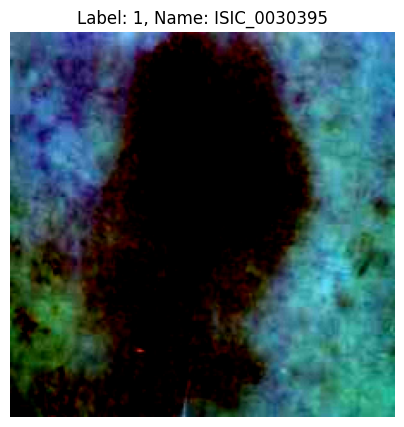

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8284159..1.6322898].


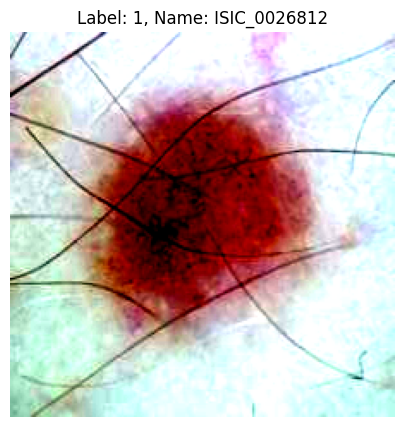

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4342296..1.2246022].


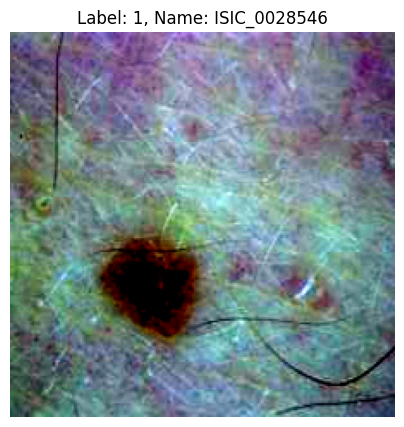

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4519552..1.4550343].


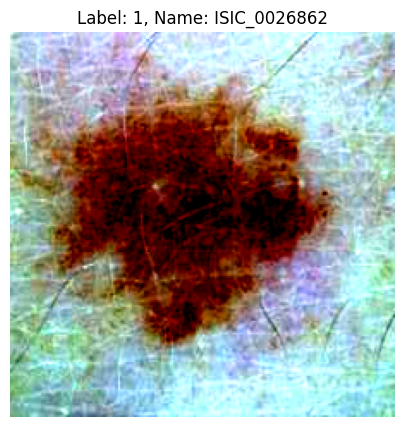

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0653331..1.5082109].


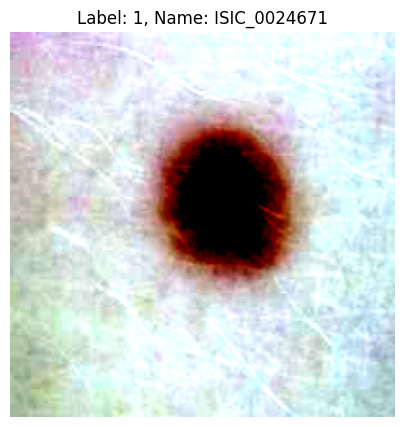

In [22]:
# Load dataset for center_id = 1
train_loader, _ = load_dataset(center_id=1)

# Number of batches to process
num_batches = 1

# Iterate through the DataLoader
for batch_idx, (images, labels, image_names) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"Images shape: {images.shape}")  # Shape of the image batch
    print(f"Labels: {labels}")  # Labels for the batch
    print(f"Image names: {image_names}")  # Names of the images
    
    # Print the first 5 images in the batch
    for i in range(min(5, len(images))):  # Ensure we don't exceed the batch size
        plt.figure(figsize=(5, 5))
        plt.imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(f"Label: {labels[i]}, Name: {image_names[i]}")
        plt.axis('off')
        plt.show()
    
    # Stop after printing the specified number of batches
    if batch_idx >= num_batches - 1:
        break

#### Class Distribution for non-iid Dataset (original)

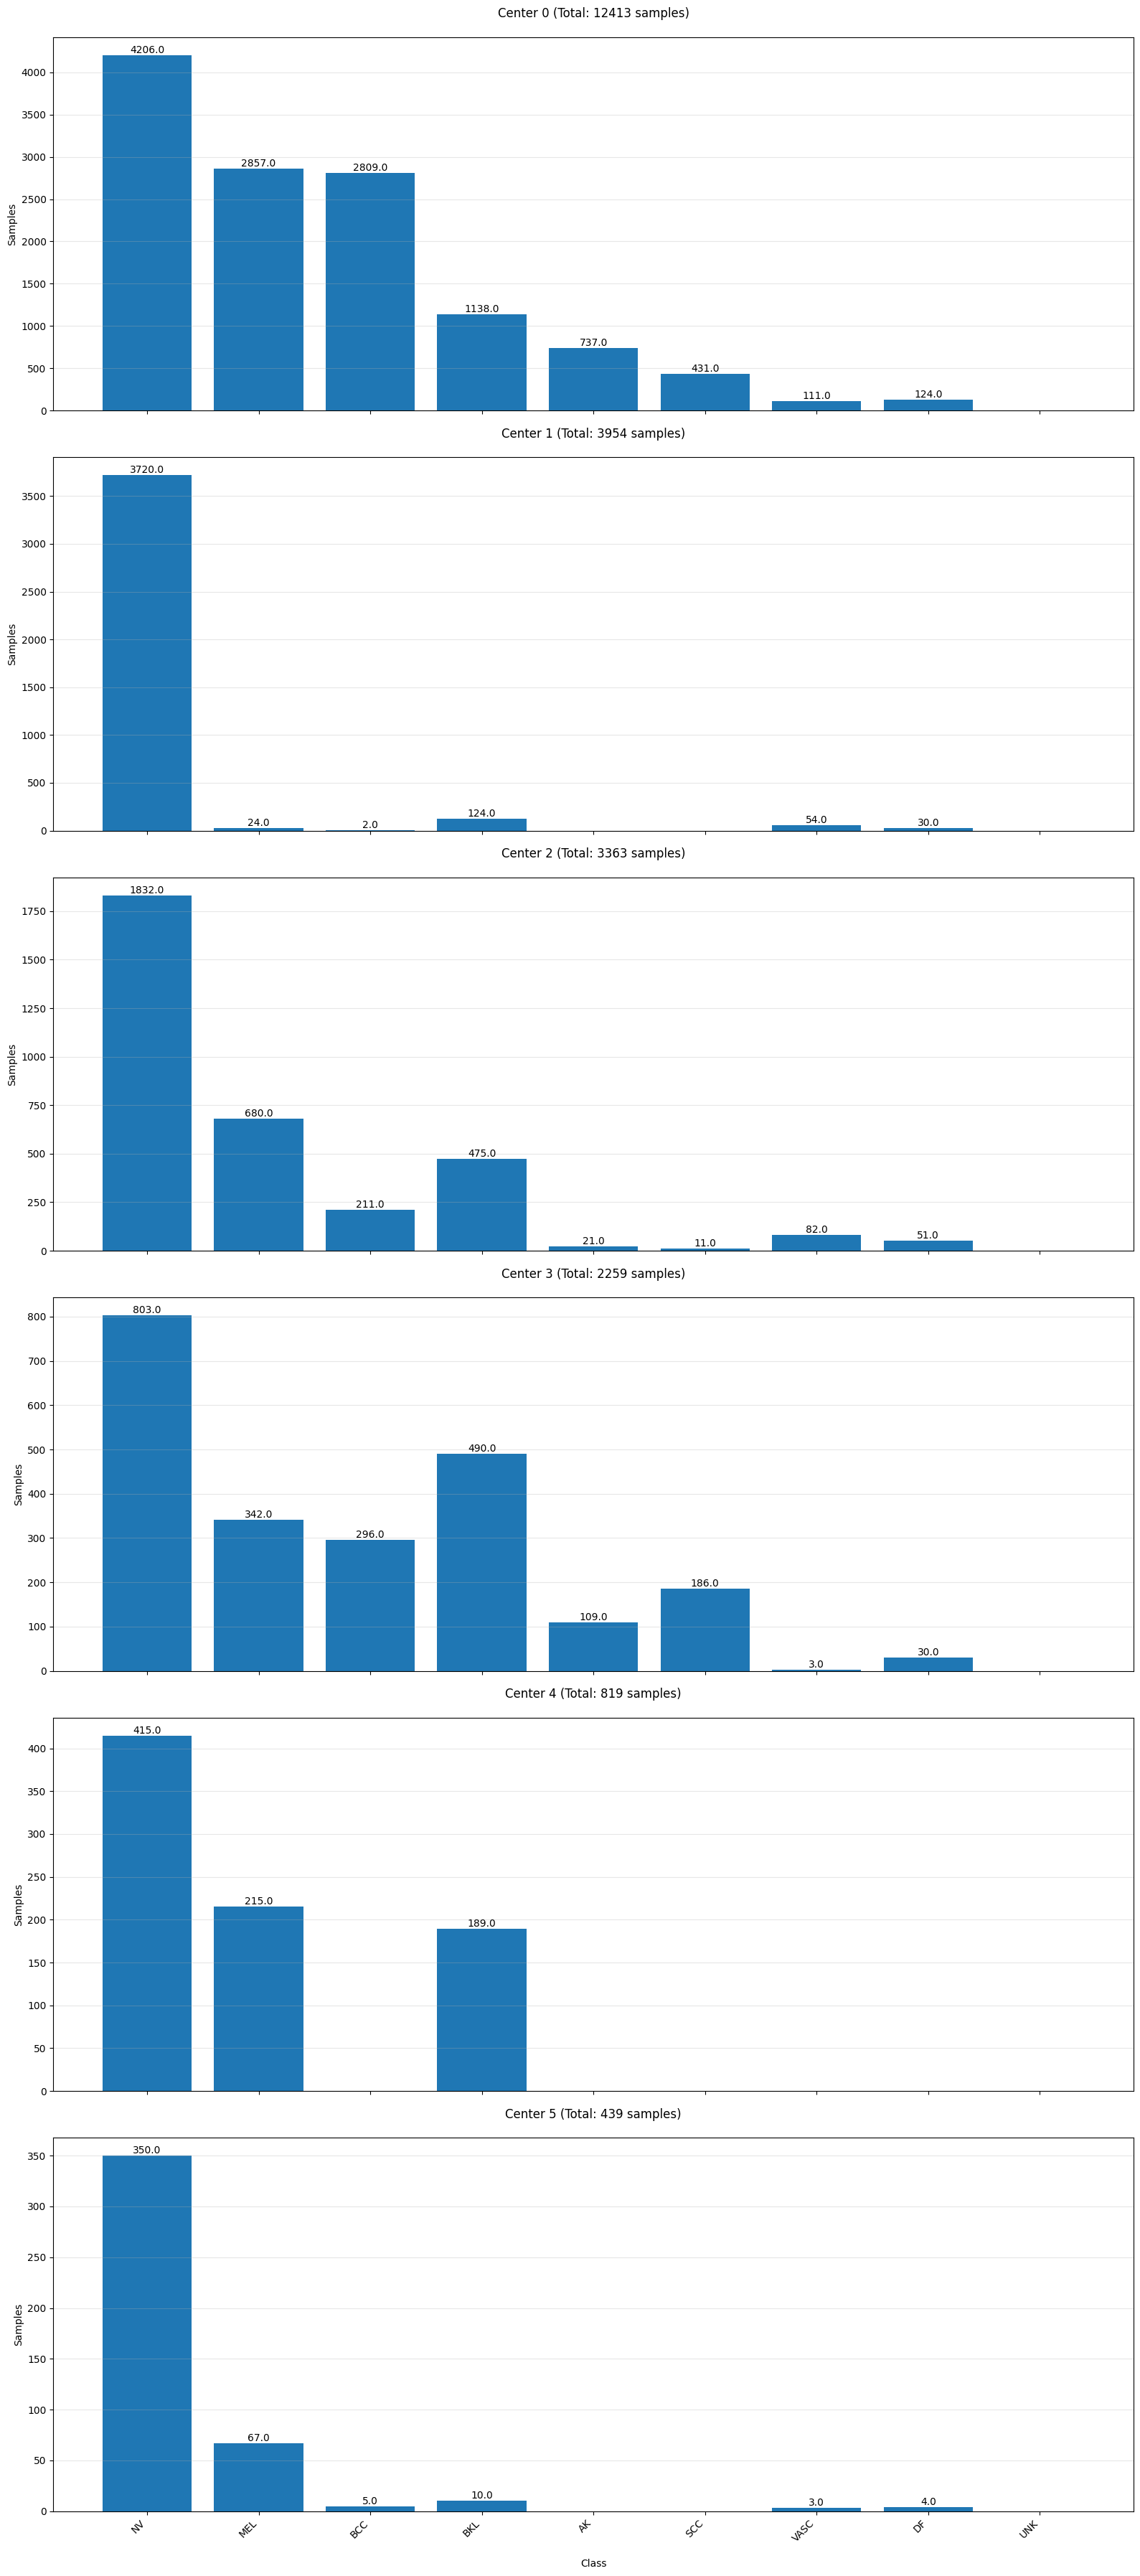

In [6]:
split_file = os.path.join("isic_dataset", "train_test_split")
df = pd.read_csv(split_file)

# Get class names from the one-hot encoded columns (exclude non-class columns)
class_columns = df.columns[1:-4]  # Assuming columns order: image, classes..., target, center, fold, fold2
global_order = df[class_columns].sum().sort_values(ascending=False).index.tolist()

# Get all unique centers
centers = df['center'].unique()
centers.sort()

# Create subplots
fig, axs = plt.subplots(nrows=len(centers), ncols=1, 
                        figsize=(16, 6*len(centers)),
                        sharex=True)  # Share x-axis for direct comparison

for idx, center_id in enumerate(centers):
    # Filter data for current center
    center_df = df[df['center'] == center_id]
    
    # Get class distribution in global order
    class_dist = (center_df[class_columns]
                    .sum()
                    .reindex(global_order, fill_value=0))  # Maintain global order
    
    # Create plot
    ax = axs[idx] if len(centers) > 1 else axs
    bars = ax.bar(class_dist.index, class_dist.values)
    
    # Formatting
    ax.set_title(f'Center {center_id} (Total: {len(center_df)} samples)', pad=20)
    ax.set_ylabel('Samples')
    ax.grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, height, 
                    f'{height}', ha='center', va='bottom')

# Common x-axis label
axs[-1].set_xlabel('Class', labelpad=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Class Distribution for iid Dataset

In [7]:
split_file = os.path.join("isic_dataset", "iid_partitions")
df = pd.read_csv(split_file)

print(df.groupby(['center', 'fold']).size().reset_index(name='count'))

    center   fold  count
0        0   test   2483
1        0  train   9930
2        1   test    791
3        1  train   3163
4        2   test    673
5        2  train   2690
6        3   test    452
7        3  train   1807
8        4   test    164
9        4  train    655
10       5   test     88
11       5  train    351


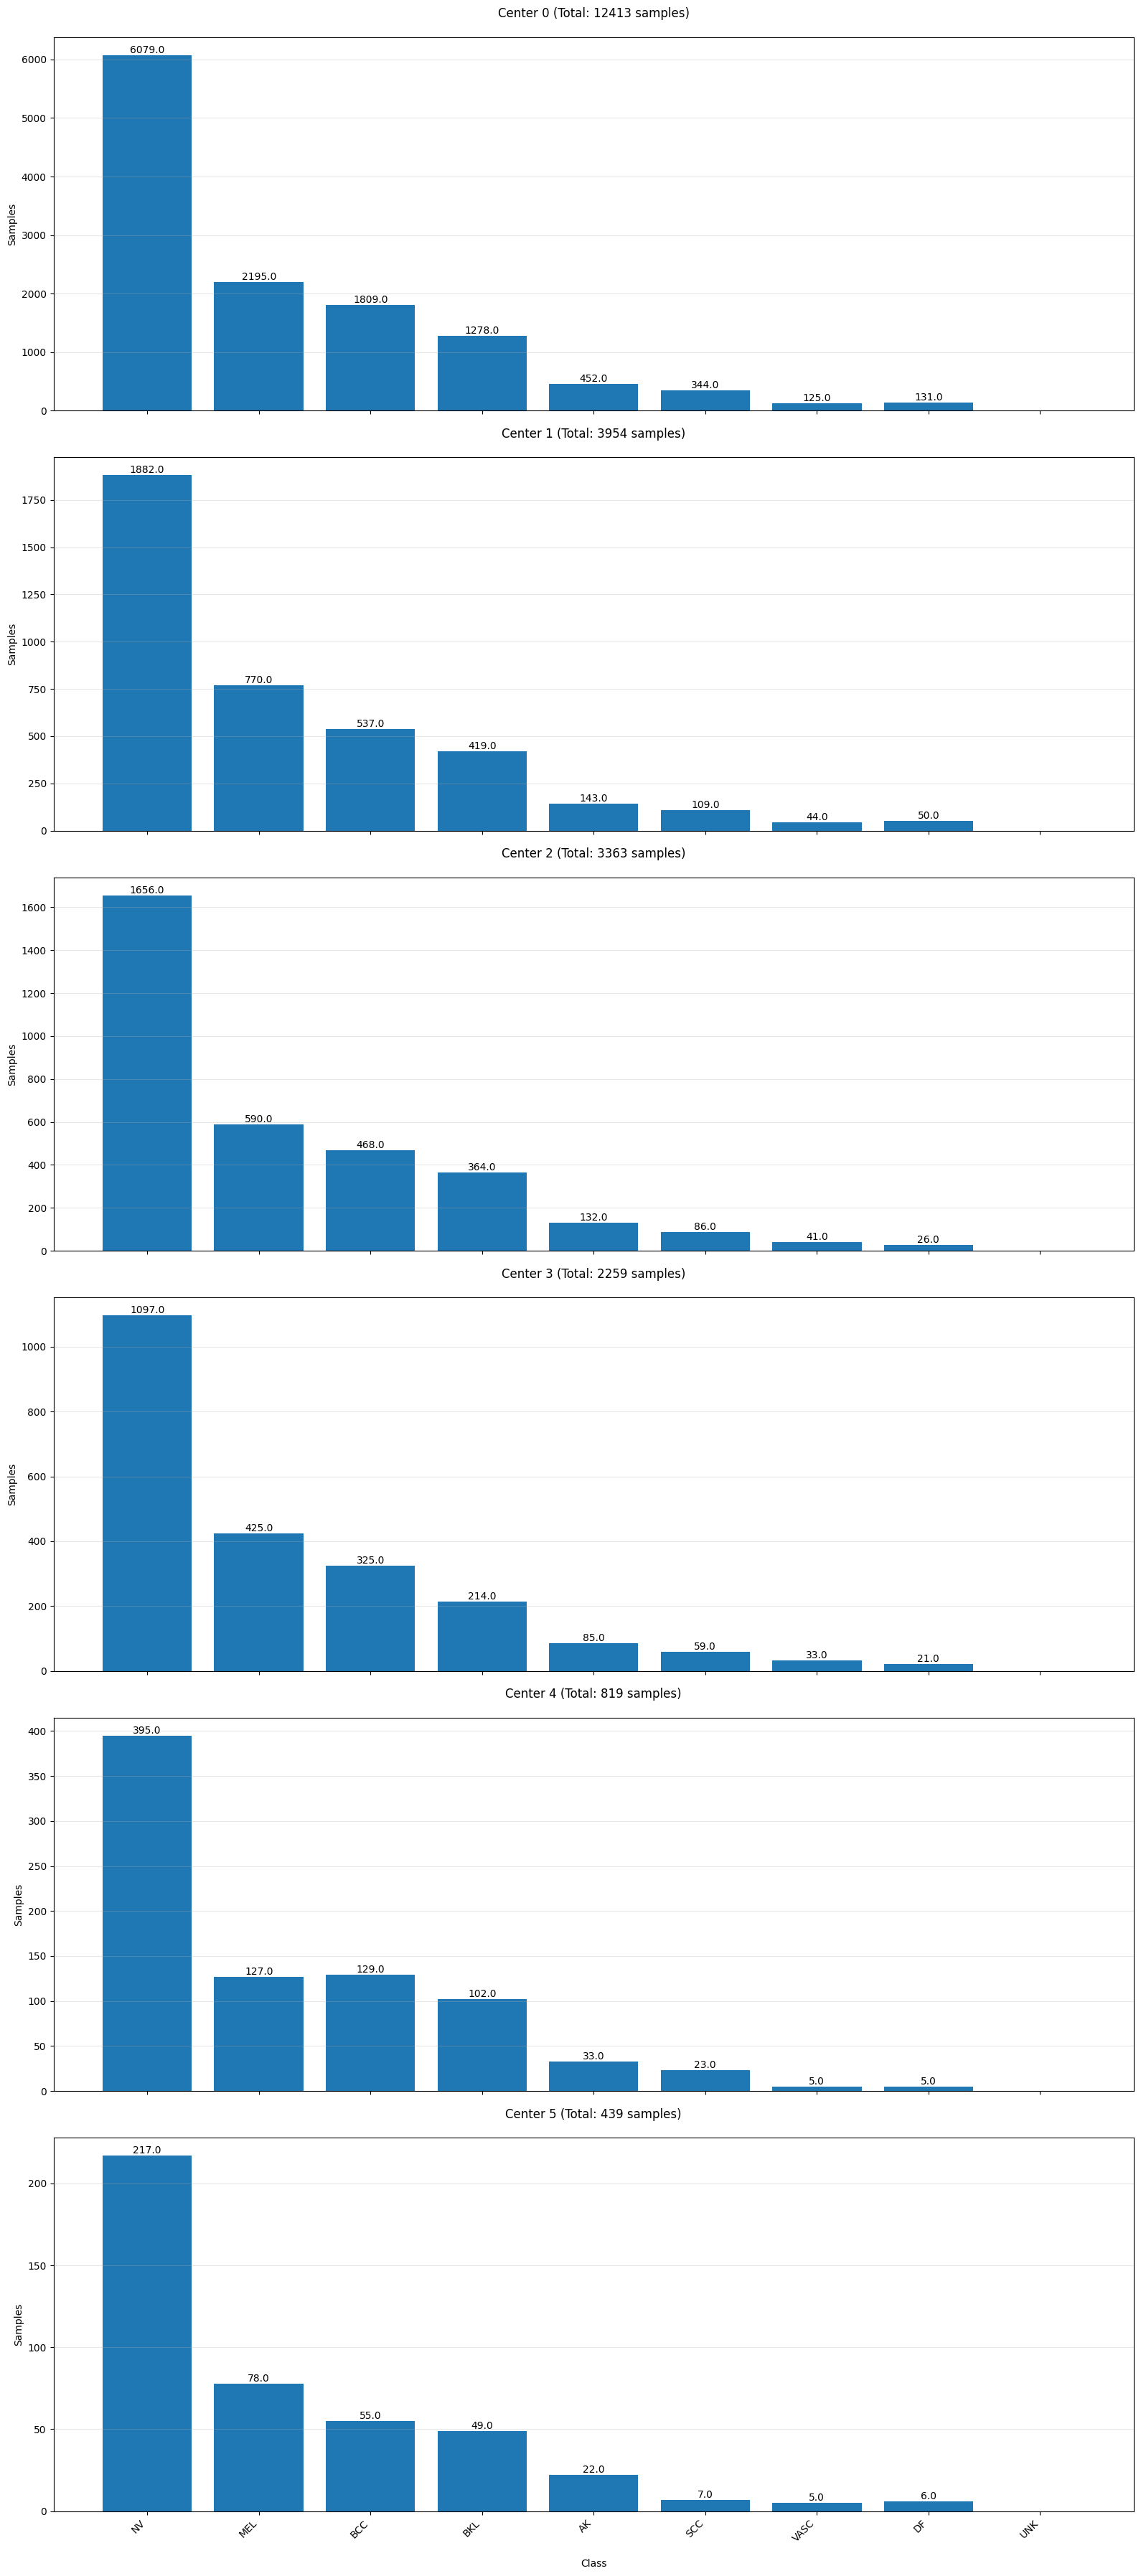

In [8]:
# Get class names from the one-hot encoded columns (exclude non-class columns)
class_columns = df.columns[2:-4]  # Assuming columns order: image, classes..., target, center, fold, fold2
global_order = df[class_columns].sum().sort_values(ascending=False).index.tolist()

# Get all unique centers
centers = df['center'].unique()
centers.sort()

# Create subplots
fig, axs = plt.subplots(nrows=len(centers), ncols=1, 
                        figsize=(16, 6*len(centers)),
                        sharex=True)  # Share x-axis for direct comparison

for idx, center_id in enumerate(centers):
    # Filter data for current center
    center_df = df[df['center'] == center_id]
    
    # Get class distribution in global order
    class_dist = (center_df[class_columns]
                    .sum()
                    .reindex(global_order, fill_value=0))  # Maintain global order
    
    # Create plot
    ax = axs[idx] if len(centers) > 1 else axs
    bars = ax.bar(class_dist.index, class_dist.values)
    
    # Formatting
    ax.set_title(f'Center {center_id} (Total: {len(center_df)} samples)', pad=20)
    ax.set_ylabel('Samples')
    ax.grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, height, 
                    f'{height}', ha='center', va='bottom')

# Common x-axis label
axs[-1].set_xlabel('Class', labelpad=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Federated Learning

## Models

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) 
        
        # Update the input size for fc1
        self.fc1 = nn.Linear(32 * 56 * 56, 64)  
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # 224 → 112
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # 112 → 56

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class EfficientNetTransferLearning(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        # Load pretrained model
        self.base = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        
        # Unfreeze all layers
        for param in self.base.parameters():
            param.requires_grad = True

        # Get correct input features for classifier
        in_features = self.base.classifier[1].in_features  
        
        # Replace classifier with new trainable layers
        self.base.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base(x)

In [7]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

class FLFriendlyEfficientNet(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        # Load pretrained EfficientNet
        self.base = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        
        # Freeze base layers
        
        for param in self.base.parameters():
            param.requires_grad = False
        
        # Remove EfficientNet's classifier
        self.base.classifier = nn.Identity()  # Output shape: [batch, 1280]
        
        # Trainable classifier (BN-free)
        self.classifier = nn.Sequential(
            # Global Average Pooling (reduces spatial dims first)
            nn.AdaptiveAvgPool2d((1, 1)),  # Output: [batch, 1280, 1, 1]
            nn.Flatten(),
            
            # Feature projector (smaller hidden dims)
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.3),  # Reduced dropout
            
            # Final classifier
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base.features(x)  # Shape: [batch, 1280, 7, 7]
        x = self.classifier(x)
        return x

## Helper Functions

In [6]:
def compute_global_class_weights(data_dir="isic_dataset"):
    # Load metadata
    split_file = os.path.join(data_dir, "train_test_split")
    df = pd.read_csv(split_file)
    
    # Filter training data
    train_df = df[df["fold"] == "train"]
    
    # Get class counts (assuming "target" column holds class indices)
    class_counts = train_df["target"].value_counts().sort_index().values
    
    # Compute inverse frequency weights
    epsilon = 1e-5  # Avoid division by zero
    class_weights = 1.0 / (class_counts + epsilon)
    class_weights = class_weights / class_weights.sum()  # Normalize
    
    return class_weights.tolist()  # Convert to list for JSON serialization

# Precompute once at server startup
GLOBAL_CLASS_WEIGHTS = compute_global_class_weights()

In [7]:
def train(net, trainloader, epochs: int, config, verbose=False):
    """Train the network on the training set."""
    class_weights = torch.tensor(GLOBAL_CLASS_WEIGHTS).to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(net.parameters())

    # Check if FedProx
    global_params = None
    fedProx, proximal_mu = config["fedProx"], config["proximal_mu"]
    if fedProx:
        global_params = copy.deepcopy(net).parameters()

    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            loss = criterion(outputs, labels)


            if fedProx:
                proximal_term = 0.0
                for local_weights, global_weights in zip(net.parameters(), global_params):
                    proximal_term += (local_weights - global_weights).norm(2)
            
                loss += (proximal_mu / 2) * proximal_term
            
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    true_labels = []
    predicted_labels = []

    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # to calculate balanced accuracy
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    loss /= len(testloader.dataset)
    accuracy = correct / total

    balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)

    return loss, balanced_acc

In [8]:
def set_parameters(net, parameters: List[np.ndarray]):
    """Set parameters for the full model (trainable + non-trainable)."""
    param_keys = list(net.state_dict().keys())  # Get parameter keys
    if len(param_keys) != len(parameters):
        raise ValueError(f"Mismatch in parameter sizes: Expected {len(param_keys)}, got {len(parameters)}")

    new_state_dict = OrderedDict({k: torch.tensor(v) for k, v in zip(param_keys, parameters)})
    net.load_state_dict(new_state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

## Initialising Client Parameters

In [9]:
class IsicClient(NumPyClient):
    
    def __init__(self, net, trainloader, testloader):
        self.net = net
        self.trainloader = trainloader
        self.testloader = testloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):

        # Read values from config
        local_epochs = config["local_epochs"]
        print("Local Epoch = ", local_epochs)

        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs, config=config)
    
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.testloader)
        return float(loss), len(self.testloader), {"balanced_accuracy": float(accuracy)}

def client_fn(context: Context):
    """Returns an IsicClient containing its data partition."""
    # Extract partition_id (center_id) from the context
    partition_id = int(context.node_config["partition-id"])
    
    # Load the dataset for the given partition_id
    train_loader, test_loader = load_dataset(center_id=partition_id, batch_size=32)
    
    # Instantiate the model (only once)
    model = SimpleCNN(num_classes=8).to(DEVICE)
    # model = EfficientNetTransferLearning(num_classes=8).to(DEVICE)
    # model = FLFriendlyEfficientNet(num_classes=8).to(DEVICE)
    
    # Create and return the IsicClient
    return IsicClient(model, train_loader, test_loader).to_client()

def client_iid_fn(context: Context):
    """Returns an IsicClient containing its data partition."""
    # Extract partition_id (center_id) from the context
    partition_id = int(context.node_config["partition-id"])
    
    # Load the dataset for the given partition_id
    train_loader, test_loader = load_dataset(center_id=partition_id, batch_size=32, iid=True)
    
    # Instantiate the model (only once)
    model = SimpleCNN(num_classes=8).to(DEVICE)
    #model = EfficientNetTransferLearning(num_classes=8).to(DEVICE)
    
    # Create and return the IsicClient
    return IsicClient(model, train_loader, test_loader).to_client()



# Construct the ClientApp passing the client generation function
client = ClientApp(client_fn=client_fn)
client_iid = ClientApp(client_fn=client_iid_fn)



## Initialising Server Parameters (non-iid)

In [10]:
# Create an instance of the model and get the parameters
params = get_parameters(SimpleCNN())
#params = get_parameters(EfficientNetTransferLearning())

backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.33}}

NUM_CLIENTS = 6

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def balanced_weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Simple average of balanced accuracies
    balanced_accuracies = [m["balanced_accuracy"] for _, m in metrics]
    return {"balanced_accuracy": np.mean(balanced_accuracies).item()}

def get_on_fit_config_fn(local_epochs: int, fedProx: bool = False, proximal_mu: int = 0.1):
    """Return a function which returns training configurations."""

    def fit_config(server_round: int):
        """Return a configuration with static batch size and (local) epochs."""
        config = {
            "local_epochs": local_epochs,
            "fedProx": fedProx,
            "proximal_mu": proximal_mu,
        }
        return config

    return fit_config



### FedAvg

In [24]:
from flwr.server.strategy import FedAvg

# Define the server configuration
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """
    # Define a strategy (e.g., Federated Averaging)
    strategy = FedAvg(
        fraction_fit=1.0,  # Sample 100% of clients for training
        fraction_evaluate=1.0,  # Sample 100% of clients for evaluation
        min_available_clients=NUM_CLIENTS,  # Minimum number of clients available
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
    )

    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)

    return ServerAppComponents(strategy=strategy, config=config)

# Create the server app
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      


INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=40344) 2025-03-24 05:34:17.117324: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35468) Local Epoch =  1
(ClientAppActor pid=40344) Local Epoch =  1
(ClientAppActor pid=47940) Local Epoch =  1
(ClientAppActor pid=40344) Local Epoch =  1
(ClientAppActor pid=47940) Local Epoch =  1
(ClientAppActor pid=40344) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=47940) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=47940)   warnings.warn("y_pred contains classes not in y_true")
(pid=47940) 2025-03-24 05:34:19.754950: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
(ClientAppActor pid=40344) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40344)   warnings.w

(ClientAppActor pid=40344) Local Epoch =  1
(ClientAppActor pid=47940) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35468) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=35468)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=35468) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=35468)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35468) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=35468) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40344) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40344)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=35468) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=35468)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40344) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=40344) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40344) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40344)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=47940) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=47940)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=47940) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=47940)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=47940) c:\Users\ASUS\App

(ClientAppActor pid=40344) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=47940) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=47940) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=47940)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
(ClientAppActor pid=35468) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=35468)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40344) Local Epoch =  1
(ClientAppActor pid=35468) Local Epoch =  1
(ClientAppActor pid=40344) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=47940) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=47940) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=47940)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=40344) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40344)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40344) Local Epoch =  1
(ClientAppActor pid=47940) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=47940) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=47940)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35468) Local Epoch =  1
(ClientAppActor pid=40344) Local Epoch =  1
(ClientAppActor pid=35468) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35468) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=35468)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35468) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=35468) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40344) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40344)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=47940) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=47940) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35468) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=35468)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 427.28s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05983945550847018
INFO :      		round 2: 0.04881672390533083
INFO :      		round 3: 0.04953946009382558
INFO :      		round 4: 0.0476867679195888
INFO :      		round 5: 0.048685580081418184
INFO :      		round 6: 0.046146826958347376
INFO :      		round 7: 0.04656929889619877
INFO :      		round 8: 0.045418063566325516

(ClientAppActor pid=40344) Local Epoch =  1


(ClientAppActor pid=35468) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=35468)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


In [66]:
# FedAvg with 2 local epochs

# Define the server configuration
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """
    # Define a strategy (e.g., Federated Averaging)
    strategy = FedAvg(
        fraction_fit=1.0,  # Sample 100% of clients for training
        fraction_evaluate=1.0,  # Sample 100% of clients for evaluation
        min_available_clients=NUM_CLIENTS,  # Minimum number of clients available
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=2),
    )

    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)

    return ServerAppComponents(strategy=strategy, config=config)

# Create the server app
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      


INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=36564) 2025-03-23 19:22:22.170053: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5572) Local Epoch =  2
(ClientAppActor pid=39568) Local Epoch =  2 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36564) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36564)   warnings.warn("y_pred contains classes not in y_true")
(pid=5572) 2025-03-23 19:22:23.621209: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39568) Local Epoch =  2 [repeated 3x across cluster]
(ClientAppActor pid=36564) Local Epoch =  2 [repeated 4x across cluster]
(ClientAppActor pid=39568) Local Epoch =  2


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36564) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=36564)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39568) Local Epoch =  2
(ClientAppActor pid=39568) Local Epoch =  2 [repeated 3x across cluster]
(ClientAppActor pid=5572) Local Epoch =  2
(ClientAppActor pid=39568) Local Epoch =  2


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=5572) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=5572)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36564) Local Epoch =  2
(ClientAppActor pid=39568) Local Epoch =  2
(ClientAppActor pid=36564) Local Epoch =  2 [repeated 2x across cluster]
(ClientAppActor pid=39568) Local Epoch =  2 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36564) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=36564)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36564) Local Epoch =  2
(ClientAppActor pid=39568) Local Epoch =  2
(ClientAppActor pid=36564) Local Epoch =  2 [repeated 2x across cluster]
(ClientAppActor pid=39568) Local Epoch =  2
(ClientAppActor pid=39568) Local Epoch =  2


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39568) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=39568)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39568) Local Epoch =  2
(ClientAppActor pid=36564) Local Epoch =  2
(ClientAppActor pid=39568) Local Epoch =  2 [repeated 2x across cluster]
(ClientAppActor pid=36564) Local Epoch =  2
(ClientAppActor pid=39568) Local Epoch =  2


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36564) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=36564)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36564) Local Epoch =  2
(ClientAppActor pid=39568) Local Epoch =  2
(ClientAppActor pid=36564) Local Epoch =  2 [repeated 2x across cluster]
(ClientAppActor pid=36564) Local Epoch =  2 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39568) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=39568)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5572) Local Epoch =  2
(ClientAppActor pid=39568) Local Epoch =  2
(ClientAppActor pid=5572) Local Epoch =  2 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=5572) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=5572)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5572) Local Epoch =  2 [repeated 2x across cluster]
(ClientAppActor pid=5572) Local Epoch =  2 [repeated 3x across cluster]
(ClientAppActor pid=36564) Local Epoch =  2 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36564) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=36564)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39568) Local Epoch =  2
(ClientAppActor pid=36564) Local Epoch =  2
(ClientAppActor pid=39568) Local Epoch =  2 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=5572) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=5572)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 638.79s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.058182983932629405
INFO :      		round 2: 0.050120630801594915
INFO :      		round 3: 0.05118496456267512
INFO :      		round 4: 0.047043747172599425
INFO :      		round 5: 0.05346983093410487
INFO :      		round 6: 0.05330830960370427
INFO :      		round 7: 0.05362290780440222
INFO :      		round 8: 0.0571036466828772
I

(ClientAppActor pid=36564) Local Epoch =  2


(ClientAppActor pid=36564) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36564)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


### FedAdam

In [67]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=43316) 2025-03-23 19:33:26.283247: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=39656) Local Epoch =  1
(ClientAppActor pid=39656) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=22260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=22260)   warnings.warn("y_pred contains classes not in y_true")
(pid=22260) 2025-03-23 19:33:27.765339: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=22260) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39656) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39656) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=39656)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=39656) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=39656)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39656) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39656) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=22260) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43316) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=43316)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=43316) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=43316)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39656) Local Epoch =  1
(ClientAppActor pid=43316) Local Epoch =  1
(ClientAppActor pid=39656) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=22260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=22260)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=43316) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=43316)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=43316) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=43316)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 r

(ClientAppActor pid=39656) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=22260) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=22260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=22260)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=39656) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=39656)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=39656) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=39656)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=39656) c:\Users\ASUS\App

(ClientAppActor pid=22260) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=22260) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39656) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=39656)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=39656) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=39656)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39656) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39656) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=43316) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39656) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=39656)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=22260) Local Epoch =  1
(ClientAppActor pid=43316) Local Epoch =  1
(ClientAppActor pid=43316) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43316) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=43316)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39656) Local Epoch =  1
(ClientAppActor pid=43316) Local Epoch =  1
(ClientAppActor pid=39656) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39656) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=39656)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39656) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39656) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=22260) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=22260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=22260)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 414.67s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.08026628580966651
INFO :      		round 2: 0.131152928564372
INFO :      		round 3: 0.158934754752301
INFO :      		round 4: 0.07223163939429254
INFO :      		round 5: 0.12668378966974553
INFO :      		round 6: 0.10133636158454742
INFO :      		round 7: 0.0778919631358881
INFO :      		round 8: 0.07479125782898485
INFO :

In [69]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta=0.5,
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=42584) 2025-03-23 19:47:33.196213: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=42584) Local Epoch =  1
(ClientAppActor pid=42584) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42584) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=42584)   warnings.warn("y_pred contains classes not in y_true")
(pid=39448) 2025-03-23 19:47:34.616427: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42584) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42584) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42584) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=42584)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=39448) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=39448)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=39448) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=39448)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 r

(ClientAppActor pid=42584) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42584) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=37392) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=37392) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=37392)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39448) Local Epoch =  1
(ClientAppActor pid=39448) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39448) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=39448)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37392) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42584) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42584) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=42584)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39448) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39448) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39448) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=39448)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39448) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39448) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42584) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=37392) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=37392)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42584) Local Epoch =  1
(ClientAppActor pid=39448) Local Epoch =  1
(ClientAppActor pid=42584) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39448) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=39448)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37392) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=37392) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42584) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=42584)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37392) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=37392) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 417.27s
INFO :      	History (loss, distributed):
INFO :      		round 1: 7264.654013481088
INFO :      		round 2: 2792.420572152538
INFO :      		round 3: 1979.9453558668417
INFO :      		round 4: 339.89790797694616
INFO :      		round 5: 168.125150585401
INFO :      		round 6: 0.08270276074724248
INFO :      		round 7: 0.07514732813339803
INFO :      		round 8: 0.06784953041258633
INFO :      		round 9: 0.06271855347508257
INFO :      		round 10: 0.06021976604528642
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.20216415523654377),
INFO :      	                       (2, 0.21663519508870924),
INFO :      	                       (3, 0.06660268698196115),
INFO :      	  

(ClientAppActor pid=42584) Local Epoch =  1


(ClientAppActor pid=39448) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=39448)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]


In [70]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta=0.01,
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=35996) 2025-03-23 19:54:35.008952: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=38888) Local Epoch =  1
(ClientAppActor pid=38888) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=16120) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=16120)   warnings.warn("y_pred contains classes not in y_true")
(pid=16120) 2025-03-23 19:54:36.420253: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
(ClientAppActor pid=16120) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=16120)   warnings.warn("y_pred contains classes 

(ClientAppActor pid=38888) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=16120) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35996) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=35996)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16120) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=16120) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38888) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=38888)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=38888) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=38888)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38888) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=38888) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=35996) Local Epoch =  1
(ClientAppActor pid=35996) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35996) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=35996)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=35996) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=35996)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16120) Local Epoch =  1
(ClientAppActor pid=38888) Local Epoch =  1
(ClientAppActor pid=16120) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=38888) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35996) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=35996)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35996) Local Epoch =  1
(ClientAppActor pid=35996) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=16120) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35996) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=35996)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=38888) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=38888)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38888) Local Epoch =  1
(ClientAppActor pid=16120) Local Epoch =  1
(ClientAppActor pid=16120) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35996) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=35996)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=16120) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=16120)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=16120) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=16120)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=16120) c:\Users\ASUS\App

(ClientAppActor pid=38888) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=35996) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=16120) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=16120)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16120) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=16120) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=38888) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38888) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=38888)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35996) Local Epoch =  1
(ClientAppActor pid=38888) Local Epoch =  1
(ClientAppActor pid=35996) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=35996) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=16120) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=16120)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 416.29s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0660571653835812
INFO :      		round 2: 0.05424789574091197
INFO :      		round 3: 0.049153876339717795
INFO :      		round 4: 0.04826017554071942
INFO :      		round 5: 0.049660244290749674
INFO :      		round 6: 0.05577130416131835
INFO :      		round 7: 0.06958263982314936
INFO :      		round 8: 0.0793335400882843
I

In [68]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta=0.001,
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=42672) 2025-03-23 19:40:24.501242: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=20664) Local Epoch =  1
(ClientAppActor pid=20664) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42672) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=42672)   warnings.warn("y_pred contains classes not in y_true")
(pid=40816) 2025-03-23 19:40:25.888320: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=20664) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=20664) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40816) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=40816)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40816) Local Epoch =  1
(ClientAppActor pid=20664) Local Epoch =  1
(ClientAppActor pid=40816) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42672) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=42672)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42672) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42672) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40816) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40816)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=20664) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=20664)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=20664) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42672) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40816) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40816)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=20664) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=20664)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=20664) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=20664)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x ac

(ClientAppActor pid=20664) Local Epoch =  1
(ClientAppActor pid=40816) Local Epoch =  1
(ClientAppActor pid=20664) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40816) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40816)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=42672) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=42672)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=42672) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=42672)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 r

(ClientAppActor pid=20664) Local Epoch =  1
(ClientAppActor pid=42672) Local Epoch =  1
(ClientAppActor pid=40816) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=20664) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=20664)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42672) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42672) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42672) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=42672)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=40816) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40816)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42672) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=20664) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42672) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=42672)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=42672) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=42672)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42672) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=40816) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42672) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=42672)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 425.10s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06513498169383371
INFO :      		round 2: 0.06668149133179688
INFO :      		round 3: 0.0670458928063034
INFO :      		round 4: 0.0671416122293563
INFO :      		round 5: 0.0667291482389892
INFO :      		round 6: 0.06622626260442126
INFO :      		round 7: 0.06573726273622015
INFO :      		round 8: 0.0651161525824492
INFO 

(ClientAppActor pid=42672) Local Epoch =  1


(ClientAppActor pid=40816) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40816)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


In [71]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        
        eta_l=0.5, # default value
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=39420) 2025-03-23 20:01:35.090936: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=33388) Local Epoch =  1
(ClientAppActor pid=33388) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7892) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=7892)   warnings.warn("y_pred contains classes not in y_true")
(pid=33388) 2025-03-23 20:01:36.552197: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7892) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=7892) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=33388) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=33388)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=33388) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=33388) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39420) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7892) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=7892)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7892) Local Epoch =  1
(ClientAppActor pid=39420) Local Epoch =  1
(ClientAppActor pid=39420) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39420) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=39420)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=33388) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=33388) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7892) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=7892)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=33388) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=33388) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39420) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=39420)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7892) Local Epoch =  1
(ClientAppActor pid=39420) Local Epoch =  1
(ClientAppActor pid=39420) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7892) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=7892)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7892) Local Epoch =  1
(ClientAppActor pid=39420) Local Epoch =  1
(ClientAppActor pid=39420) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=33388) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=33388)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39420) Local Epoch =  1
(ClientAppActor pid=7892) Local Epoch =  1
(ClientAppActor pid=39420) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=33388) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=33388)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=33388) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=7892) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=33388) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=33388)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 418.04s
INFO :      	History (loss, distributed):
INFO :      		round 1: 3.581477028259191
INFO :      		round 2: 0.15827585170020972
INFO :      		round 3: 1.018372487876475
INFO :      		round 4: 1.1888745521771404
INFO :      		round 5: 0.11471624421732336
INFO :      		round 6: 0.311707655641531
INFO :      		round 7: 0.14442460931194084
INFO :      		round 8: 0.08196201788442009
INFO :  

(ClientAppActor pid=33388) Local Epoch =  1


(ClientAppActor pid=7892) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=7892)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


In [72]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        
        eta_l=0.01, # default value
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=37916) 2025-03-23 20:08:37.363124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=37916) Local Epoch =  1
(ClientAppActor pid=37916) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=25900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=25900)   warnings.warn("y_pred contains classes not in y_true")
(pid=18264) 2025-03-23 20:08:38.823127: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37916) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=18264) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=25900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=25900)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37916) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=37916) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=37916) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=37916)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=18264) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=37916) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=25900) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=37916) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=37916)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=37916) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=37916)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=37916) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=37916)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 r

(ClientAppActor pid=25900) Local Epoch =  1
(ClientAppActor pid=37916) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=37916) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=37916)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=18264) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=18264)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=18264) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=18264)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 r

(ClientAppActor pid=37916) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=37916) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=25900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=25900)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=37916) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=37916)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37916) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=37916) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=37916) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=37916)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=18264) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=18264) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=18264) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=18264)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=25900) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=37916) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=25900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=25900)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=25900) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=25900) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=37916) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=37916)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 407.24s
INFO :      	History (loss, distributed):
INFO :      		round 1: 4.1510244718837
INFO :      		round 2: 0.06550540219873313
INFO :      		round 3: 0.20835309117729317
INFO :      		round 4: 0.06482540748804765
INFO :      		round 5: 0.07224030311753196
INFO :      		round 6: 0.06939197432598118
INFO :      		round 7: 0.14845648823692453
INFO :      		round 8: 0.08136573267114516
INFO 

(ClientAppActor pid=37916) Local Epoch =  1 [repeated 2x across cluster]


(ClientAppActor pid=18264) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=18264)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


In [73]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        
        eta_l=0.001, # default value
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=42432) 2025-03-23 20:15:27.957060: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=16812) Local Epoch =  1
(ClientAppActor pid=40240) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=16812) Local Epoch =  1
(ClientAppActor pid=42432) Local Epoch =  1
(ClientAppActor pid=42432) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=16812) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=16812)   warnings.warn("y_pred contains classes not in y_true")
(pid=16812) 2025-03-23 20:15:29.480044: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
(ClientAppActor pid=16812) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=16812)   warnings.warn("y_pred contains classes 

(ClientAppActor pid=16812) Local Epoch =  1
(ClientAppActor pid=42432) Local Epoch =  1
(ClientAppActor pid=16812) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=16812) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40240) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40240)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=40240) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40240)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40240) Local Epoch =  1
(ClientAppActor pid=42432) Local Epoch =  1
(ClientAppActor pid=42432) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=16812) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=16812)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42432) Local Epoch =  1
(ClientAppActor pid=16812) Local Epoch =  1
(ClientAppActor pid=42432) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42432) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=42432)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=40240) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40240)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42432) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42432) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42432) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42432) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=42432)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42432) Local Epoch =  1
(ClientAppActor pid=16812) Local Epoch =  1
(ClientAppActor pid=42432) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=16812) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=16812)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16812) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=16812) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=16812) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=16812)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42432) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42432) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42432) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=42432)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=16812) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=16812)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16812) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=16812) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42432) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=42432)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=40240) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40240)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40240) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42432) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40240) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40240)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 430.42s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.9098458790504257
INFO :      		round 2: 0.06783317927649342
INFO :      		round 3: 0.2872732605453818
INFO :      		round 4: 0.06530796107646523
INFO :      		round 5: 0.07051190643850523
INFO :      		round 6: 0.07702262085476956
INFO :      		round 7: 0.0908247796317377
INFO :      		round 8: 0.24171988828920396
INFO

In [ ]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        
        beta_1=0.99,
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=40828) 2025-03-23 20:22:43.621750: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=41248) Local Epoch =  1
(ClientAppActor pid=41248) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=41248) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=41248)   warnings.warn("y_pred contains classes not in y_true")
(pid=37596) 2025-03-23 20:22:45.589440: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
(ClientAppActor pid=41248) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=41248)   warnings.warn("y_pred contains classes 

(ClientAppActor pid=41248) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40828) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40828) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=40828)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37596) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=37596) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40828) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=40828)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40828) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40828) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40828) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=41248) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=41248)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41248) Local Epoch =  1
(ClientAppActor pid=37596) Local Epoch =  1
(ClientAppActor pid=37596) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=37596) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=37596)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41248) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=41248) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=37596) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=37596)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37596) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=37596) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=41248) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40828) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=40828)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=40828) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40828)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41248) Local Epoch =  1
(ClientAppActor pid=40828) Local Epoch =  1
(ClientAppActor pid=41248) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=40828) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=37596) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=37596)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=37596) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=37596)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41248) Local Epoch =  1
(ClientAppActor pid=37596) Local Epoch =  1
(ClientAppActor pid=41248) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=41248) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=37596) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=37596)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40828) Local Epoch =  1
(ClientAppActor pid=41248) Local Epoch =  1
(ClientAppActor pid=40828) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=41248) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=41248)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 420.53s
INFO :      	History (loss, distributed):
INFO :      		round 1: 5.726197078788501
INFO :      		round 2: 2.9402076765861582
INFO :      		round 3: 0.10868681485418161
INFO :      		round 4: 0.08004864875224234
INFO :      		round 5: 0.07727556544782561
INFO :      		round 6: 0.08049396286155609
INFO :      		round 7: 0.07550171420922824
INFO :      		round 8: 0.08474483380626316
INFO

(ClientAppActor pid=41248) Local Epoch =  1 [repeated 2x across cluster]


(ClientAppActor pid=40828) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40828)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


In [ ]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        
        beta_1=0.8,
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=43408) 2025-03-23 21:01:12.220139: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=43408) Local Epoch =  1
(ClientAppActor pid=43408) Local Epoch =  1 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=43900)   warnings.warn("y_pred contains classes not in y_true")
(pid=28104) 2025-03-23 21:01:13.265170: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=43408) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=43408) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=28104) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=28104)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=28104) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=28104)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=28104) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=28104)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 r

(ClientAppActor pid=43900) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=43900) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=43408) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=28104) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=28104)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=28104) Local Epoch =  1
(ClientAppActor pid=43408) Local Epoch =  1
(ClientAppActor pid=43408) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=43900)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=28104) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=28104) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43408) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=43408)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=43408) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=43408) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=43900)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=43900) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=43900) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=43900)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=43900) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=43900) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43408) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=43408)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=43408) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=43900) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=28104) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=28104)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
(ClientAppActor pid=28104) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=28104)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=28104) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=28104) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=43408) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=28104) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=28104)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=43408) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=43408)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 411.22s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.061888535942855184
INFO :      		round 2: 0.3987071685336284
INFO :      		round 3: 0.1361366541133083


In [ ]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        
        beta_2=0.9,
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=36220) 2025-03-23 21:08:08.469064: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=36220) Local Epoch =  1
(ClientAppActor pid=36220) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36220) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36220)   warnings.warn("y_pred contains classes not in y_true")
(pid=25240) 2025-03-23 21:08:10.065462: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
(ClientAppActor pid=36220) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36220)   warnings.warn("y_pred contains classes 

(ClientAppActor pid=25240) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=25240) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=36220) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36220) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=36220)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
(ClientAppActor pid=42652) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=42652)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42652) Local Epoch =  1
(ClientAppActor pid=42652) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=25240) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=25240)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=25240) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=25240)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42652) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42652) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=36220) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36220) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36220)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=36220) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36220)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=25240) Local Epoch =  1
(ClientAppActor pid=42652) Local Epoch =  1
(ClientAppActor pid=25240) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=25240) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=25240)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42652) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42652) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=25240) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=25240)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=25240) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=36220) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=25240) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=25240)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=25240) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=25240) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=25240) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36220) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=36220)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36220) Local Epoch =  1
(ClientAppActor pid=25240) Local Epoch =  1
(ClientAppActor pid=25240) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42652) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=42652)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=25240) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=25240) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42652) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=42652)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 400.92s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07329392592669558
INFO :      		round 2: 0.08289551668988145
INFO :      		round 3: 2.7032600927086747
INFO :      		round 4: 0.12780468491362473
INFO :      		round 5: 0.1802772770412738
INFO :      		round 6: 0.1512390652664073
INFO :      		round 7: 0.08130375178371234
INFO :      		round 8: 0.08711187064307185
INFO

(ClientAppActor pid=42652) Local Epoch =  1 [repeated 2x across cluster]


(ClientAppActor pid=42652) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=42652)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


In [13]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        
        beta_2=0.8, # default value
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=792) 2025-03-23 21:14:53.286804: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=38640) Local Epoch =  1
(ClientAppActor pid=38640) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38640) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=38640)   warnings.warn("y_pred contains classes not in y_true")
(pid=13184) 2025-03-23 21:14:54.836591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=792) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=792) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=13184) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=13184) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=13184)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13184) Local Epoch =  1
(ClientAppActor pid=13184) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=792) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=792)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=13184) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=13184)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38640) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=38640) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=13184) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=13184) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=13184)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=13184) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=13184)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=13184) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=13184)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 r

(ClientAppActor pid=13184) Local Epoch =  1
(ClientAppActor pid=792) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=13184) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=13184)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=38640) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=38640)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=38640) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=38640)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 r

(ClientAppActor pid=38640) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=38640) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=792) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=792)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=38640) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=38640)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=38640) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=38640)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 resul

(ClientAppActor pid=792) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=792) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=38640) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=13184) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=13184)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13184) Local Epoch =  1
(ClientAppActor pid=38640) Local Epoch =  1
(ClientAppActor pid=792) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=792) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=792)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38640) Local Epoch =  1
(ClientAppActor pid=13184) Local Epoch =  1
(ClientAppActor pid=13184) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=38640) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=792) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=792)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38640) Local Epoch =  1
(ClientAppActor pid=38640) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=792) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=792)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 416.67s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06950426303462977
INFO :      		round 2: 0.07139720729051248
INFO :      		round 3: 0.06838904645382163
INFO :      		round 4: 0.1567455661275953
INFO :      		round 5: 0.0658300987811325
INFO :      		round 6: 0.05480694552272351
INFO :      		round 7: 0.06632450495732986
INFO :      		round 8: 0.06587680580276369
INFO : 

(ClientAppActor pid=792) Local Epoch =  1


(ClientAppActor pid=13184) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=13184)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


In [14]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        
        tau=1e-8,
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=35868) 2025-03-23 21:24:13.277183: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=35868) Local Epoch =  1
(ClientAppActor pid=35868) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35868) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=11360) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=35868) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11360) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=11360)   warnings.warn("y_pred contains classes not in y_true")
(pid=11360) 2025-03-23 21:24:14.801735: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
(ClientAppActor pid=11360) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=11360)   warnings.warn("y_pred contains classes 

(ClientAppActor pid=35868) Local Epoch =  1
(ClientAppActor pid=35868) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11360) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=11360)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=11360) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=11360)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11360) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=35868) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11360) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=11360)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=11360) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=11360)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35868) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=35868) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=11360) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35868) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=35868)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=40264) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40264)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35868) Local Epoch =  1
(ClientAppActor pid=40264) Local Epoch =  1
(ClientAppActor pid=40264) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40264) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40264)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35868) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=40264) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11360) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=11360)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40264) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=40264) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11360) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=11360)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40264) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=35868) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40264) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=40264)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40264) Local Epoch =  1
(ClientAppActor pid=11360) Local Epoch =  1
(ClientAppActor pid=40264) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11360) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=11360)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=35868) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=35868)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 426.89s
INFO :      	History (loss, distributed):
INFO :      

(ClientAppActor pid=11360) Local Epoch =  1 [repeated 2x across cluster]


In [15]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        
        tau=1e-7,
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=43796) 2025-03-23 21:31:24.500564: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=35868) Local Epoch =  1
(ClientAppActor pid=35868) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35868) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=35868)   warnings.warn("y_pred contains classes not in y_true")
(pid=36900) 2025-03-23 21:31:26.356455: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36900) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=36900) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43796) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=43796)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35868) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=35868) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35868) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=35868)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36900) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=43796) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43796) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=43796)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
(ClientAppActor pid=35868) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=35868)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=43796) Local Epoch =  1
(ClientAppActor pid=35868) Local Epoch =  1
(ClientAppActor pid=35868) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36900)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=43796) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=43796)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=35868) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=35868)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x ac

(ClientAppActor pid=43796) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=43796) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=35868) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36900)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=36900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36900)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35868) Local Epoch =  1
(ClientAppActor pid=36900) Local Epoch =  1
(ClientAppActor pid=35868) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43796) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=43796)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=43796) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=43796) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35868) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=35868)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36900) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=43796) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=36900) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43796) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=43796)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=43796) Local Epoch =  1
(ClientAppActor pid=43796) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35868) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=35868)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 416.39s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06728811608145306
INFO :      		round 2: 0.07566697519186774
INFO :      		round 3: 0.13687541910064088
INFO :      		round 4: 0.2857196498654806
INFO :      		round 5: 0.11489343311413072
INFO :      		round 6: 0.06749980827558445
INFO :      		round 7: 0.06080824683913724
INFO :      		round 8: 0.05915877807133825
IN

(ClientAppActor pid=36900) Local Epoch =  1 [repeated 2x across cluster]


(ClientAppActor pid=36900) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36900)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


In [23]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta=0.001,
        eta_l=0.1, # default value
        beta_1=0.8, 
        beta_2=0.9, 
        tau = 1e-9 # default value
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=40)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=40, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=17260) 2025-03-24 04:56:58.836817: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true")
(pid=48712) 2025-03-24 04:57:00.646453: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes 

(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=36152) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=36152) Local Epoch =  1
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=17260) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=17260) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x ac

(ClientAppActor pid=17260) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=17260) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x ac

(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=17260) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=17260) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=17260) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=17260) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=17260) Local Epoch =  1
(ClientAppActor pid=17260) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=36152) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=17260) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=17260) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=17260) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1
(ClientAppActor pid=17260) Local Epoch =  1
(ClientAppActor pid=17260) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=17260) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=17260) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=17260) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=17260) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=17260) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=17260) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=17260) Local Epoch =  1
(ClientAppActor pid=36152) Local Epoch =  1
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=48712) c:\Users\ASUS\App

(ClientAppActor pid=36152) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=17260) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=17260) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=17260) Local Epoch =  1
(ClientAppActor pid=36152) Local Epoch =  1
(ClientAppActor pid=17260) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=17260) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=48712) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=48712)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1
(ClientAppActor pid=17260) Local Epoch =  1
(ClientAppActor pid=36152) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=36152) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=17260) Local Epoch =  1
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48712) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36152) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48712) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=17260) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=17260)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
(ClientAppActor pid=36152) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36152)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 40 round(s) in 1960.14s
INFO :      	History (loss, distributed):
INFO :     

(ClientAppActor pid=36152) Local Epoch =  1


In [13]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta=0.01,
        eta_l=0.001, 
        beta_1=0.8, 
        beta_2=0.8, 
        tau = 1e-9 # default value
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=30)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=40228) 2025-03-24 14:20:37.605074: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=40228) Local Epoch =  1
(ClientAppActor pid=11524) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true")
(pid=11524) 2025-03-24 14:20:39.492165: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes 

(ClientAppActor pid=11524) Local Epoch =  1
(ClientAppActor pid=15480) Local Epoch =  1
(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40228) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=15480) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40228) Local Epoch =  1
(ClientAppActor pid=11524) Local Epoch =  1
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 r

(ClientAppActor pid=11524) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40228) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=11524) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=15480) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=40228) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15480) Local Epoch =  1
(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=15480) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40228) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=15480) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=40228) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40228) Local Epoch =  1
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11524) Local Epoch =  1
(ClientAppActor pid=40228) Local Epoch =  1
(ClientAppActor pid=11524) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40228) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40228) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40228) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=11524) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15480) Local Epoch =  1
(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11524) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=11524) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11524) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40228) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=11524) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11524) Local Epoch =  1
(ClientAppActor pid=15480) Local Epoch =  1
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11524) Local Epoch =  1
(ClientAppActor pid=40228) Local Epoch =  1
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11524) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=11524) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15480) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=11524) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11524) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=11524)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40228) Local Epoch =  1
(ClientAppActor pid=11524) Local Epoch =  1
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40228) Local Epoch =  1
(ClientAppActor pid=15480) Local Epoch =  1
(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=11524) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11524) Local Epoch =  1
(ClientAppActor pid=11524) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40228) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=40228)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15480) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40228) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=15480) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=15480)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 1228.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0645877990926964
INFO :      		round 2: 0.06350978876096165
INFO :      		round 3: 0.056419327126804655
INFO :      		round 4: 0.05237939045068424
INFO :      		round 5: 0.05319893688137213
INFO :      		round 6: 0.05274190385931743
INFO :      		round 7: 0.05060695518123586
INFO :      		round 8: 0.05059211495206569


In [11]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta=0.01,
        eta_l=0.001, 
        beta_1=0.8, 
        beta_2=0.8, 
        tau = 1e-7 # default value
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=20)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=21164) 2025-03-24 13:24:03.740623: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off er
(pid=21164) r
(pid=21164) o
(pid=21164) r
(pid=4196) 2025-03-24 13:24:03.729696: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=21164) s from different computation orders. To turn them off, set 

(ClientAppActor pid=4196) Local Epoch =  1
(ClientAppActor pid=4196) Local Epoch =  1 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=21172) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21164) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=21164)   warnings.warn("y_pred contains classes not in y_true")
(pid=21172) 2025-03-24 13:24:04.862890: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21172) Local Epoch =  1
(ClientAppActor pid=4196) Local Epoch =  1
(ClientAppActor pid=21164) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=4196) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21172) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=21172)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21164) Local Epoch =  1
(ClientAppActor pid=21164) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=21172) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4196) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=4196)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21172) Local Epoch =  1
(ClientAppActor pid=4196) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4196) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=4196)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21164) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=21164) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4196) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=4196)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21172) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=21164) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21172) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=21172)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21172) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=21172) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=21164) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21164) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=21164)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21164) Local Epoch =  1
(ClientAppActor pid=21172) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4196) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=4196)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21172) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=4196) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=21172) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21172) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=21172)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=21172) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=21172)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4196) Local Epoch =  1
(ClientAppActor pid=4196) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=21172) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21172) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=21172)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=21172) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=21172)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21164) Local Epoch =  1
(ClientAppActor pid=21172) Local Epoch =  1
(ClientAppActor pid=4196) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4196) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=4196)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21172) Local Epoch =  1
(ClientAppActor pid=4196) Local Epoch =  1
(ClientAppActor pid=4196) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4196) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=4196)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=21172) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=21172)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4196) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=4196) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21172) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=21172)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=21172) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=21172)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4196) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=4196) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21164) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=21164)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21172) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=4196) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21164) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=21164)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4196) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=21172) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21164) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=21164)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4196) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=4196) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=21164) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21172) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=21172)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=21164) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=21164)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21164) Local Epoch =  1
(ClientAppActor pid=21172) Local Epoch =  1
(ClientAppActor pid=21172) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4196) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=4196)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=4196) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=4196)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4196) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=21172) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4196) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=4196)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4196) Local Epoch =  1
(ClientAppActor pid=21164) Local Epoch =  1
(ClientAppActor pid=4196) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4196) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=4196)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 893.07s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05869582895371352
INFO :      		round 2: 0.060686443966332965
INFO :      		round 3: 0.061397832949498646
INFO :      		round 4: 0.05882734857041146
INFO :      		round 5: 0.057234953993235534
INFO :      		round 6: 0.053489653582968845
INFO :      		round 7: 0.0531114600998956
INFO :      		round 8: 0.05210552947413643


(ClientAppActor pid=4196) Local Epoch =  1 [repeated 2x across cluster]


(ClientAppActor pid=21172) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=21172)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


### FedProx

In [16]:
from flwr.server.strategy import FedProx

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedProx(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1, fedProx=True, proximal_mu=0.1),
        proximal_mu=0.1
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=38988) 2025-03-23 21:38:24.832452: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=34624) Local Epoch =  1
(ClientAppActor pid=34624) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=34624) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=34624)   warnings.warn("y_pred contains classes not in y_true")
(pid=34624) 2025-03-23 21:38:26.577238: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38988) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=29468) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=34624) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=34624)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=34624) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=34624) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=38988) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=29468) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=29468)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=29468) Local Epoch =  1
(ClientAppActor pid=38988) Local Epoch =  1
(ClientAppActor pid=38988) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=29468) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=29468)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=29468) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=34624) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=29468) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=29468)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=29468) Local Epoch =  1
(ClientAppActor pid=34624) Local Epoch =  1
(ClientAppActor pid=29468) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=34624) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=34624)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=29468) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=29468) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38988) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=38988)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=29468) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=29468) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38988) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=38988)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38988) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=38988) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38988) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=38988)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=29468) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=29468) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=29468) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=29468)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 403.31s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05612531247618284
INFO :      		round 2: 0.052577876412349706
INFO :      		round 3: 0.04998257208361425
INFO :      		round 4: 0.053606178139893254
INFO :      		round 5: 0.05194367624680278
INFO :      		round 6: 0.050783921558023366
INFO :      		round 7: 0.043393558217491975
INFO :      		round 8: 0.046247506954727

(ClientAppActor pid=38988) Local Epoch =  1 [repeated 2x across cluster]


(ClientAppActor pid=34624) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=34624)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


In [20]:
# FedProx with proximal_mu = 0.5

from flwr.server.strategy import FedProx

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedProx(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1, fedProx=True, proximal_mu=0.5),
        proximal_mu=0.5
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=42848) 2025-03-23 21:58:59.094363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=39768) Local Epoch =  1
(ClientAppActor pid=39768) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39768) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=39768)   warnings.warn("y_pred contains classes not in y_true")
(pid=39768) 2025-03-23 21:59:00.586610: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
(ClientAppActor pid=39768) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=39768)   warnings.warn("y_pred contains classes 

(ClientAppActor pid=43028) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42848) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39768) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=39768)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42848) Local Epoch =  1
(ClientAppActor pid=43028) Local Epoch =  1
(ClientAppActor pid=43028) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42848) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=42848)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=42848) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=42848)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=43028) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=43028) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=42848) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43028) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=43028)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=39768) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=39768)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42848) Local Epoch =  1
(ClientAppActor pid=43028) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39768) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=39768)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42848) Local Epoch =  1
(ClientAppActor pid=39768) Local Epoch =  1
(ClientAppActor pid=39768) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43028) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=43028)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=43028) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=43028) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39768) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=39768)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=43028) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=43028)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39768) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=43028) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42848) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=42848)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=39768) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=39768)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39768) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39768) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43028) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=43028)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=43028) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=43028)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=43028) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=43028) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39768) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=39768)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=43028) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=43028)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=43028) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=43028)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 r

In [ ]:
from flwr.server.strategy import FedProx

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedProx(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1, fedProx=True, proximal_mu=0.3),
        proximal_mu=0.3
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=15)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      


INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=21308) 2025-03-23 21:45:30.413046: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=21308) Local Epoch =  1
(ClientAppActor pid=21308) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21308) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=21308)   warnings.warn("y_pred contains classes not in y_true")
(pid=42928) 2025-03-23 21:45:31.614672: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7496) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=7496) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7496) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=7496)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21308) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=21308) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21308) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=21308)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42928) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42928) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7496) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=7496)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42928) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42928) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42928) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=42928)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21308) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=21308) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42928) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7496) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=7496)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42928) Local Epoch =  1
(ClientAppActor pid=7496) Local Epoch =  1
(ClientAppActor pid=7496) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=42928) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=42928)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42928) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42928) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7496) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=7496)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42928) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42928) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=21308) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=21308)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7496) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42928) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7496) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=7496)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 385.65s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06384866958976185
INFO :      		round 2: 0.05061503971590321
INFO :      		round 3: 0.04839013013031039
INFO :      		round 4: 0.04790435844254668
INFO :      		round 5: 0.04779038687638726
INFO :      		round 6: 0.045844791680642406
INFO :      		round 7: 0.046468938170053
INFO :      		round 8: 0.042452547409445186
INF

(ClientAppActor pid=21308) Local Epoch =  1 [repeated 2x across cluster]


(ClientAppActor pid=21308) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=21308)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]


In [25]:
from flwr.server.strategy import FedProx

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedProx(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1, fedProx=True, proximal_mu=0.7),
        proximal_mu=0.7
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=15)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=15, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=45436) 2025-03-24 05:51:21.904224: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=45436) Local Epoch =  1
(ClientAppActor pid=5180) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=45436) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=5180) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=5180)   warnings.warn("y_pred contains classes not in y_true")
(pid=5180) 2025-03-24 05:51:25.097739: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]
(ClientAppActor pid=5180) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=5180)   warnings.warn("

(ClientAppActor pid=36700) Local Epoch =  1
(ClientAppActor pid=5180) Local Epoch =  1
(ClientAppActor pid=36700) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=5180) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=45436) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=45436)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
(ClientAppActor pid=36700) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36700)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36700) Local Epoch =  1
(ClientAppActor pid=5180) Local Epoch =  1
(ClientAppActor pid=36700) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=5180) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=45436) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=45436)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=45436) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=45436)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5180) Local Epoch =  1
(ClientAppActor pid=45436) Local Epoch =  1
(ClientAppActor pid=5180) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=45436) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36700) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36700)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=36700) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=36700)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5180) Local Epoch =  1
(ClientAppActor pid=45436) Local Epoch =  1
(ClientAppActor pid=36700) Local Epoch =  1
(ClientAppActor pid=5180) Local Epoch =  1
(ClientAppActor pid=45436) Local Epoch =  1
(ClientAppActor pid=45436) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36700) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=36700)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5180) Local Epoch =  1
(ClientAppActor pid=45436) Local Epoch =  1
(ClientAppActor pid=45436) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36700) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=36700)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45436) Local Epoch =  1
(ClientAppActor pid=36700) Local Epoch =  1
(ClientAppActor pid=45436) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=36700) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=45436) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=45436)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=45436) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=45436)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45436) Local Epoch =  1
(ClientAppActor pid=5180) Local Epoch =  1
(ClientAppActor pid=36700) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=5180) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=5180)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=5180) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=5180)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45436) Local Epoch =  1
(ClientAppActor pid=36700) Local Epoch =  1
(ClientAppActor pid=36700) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=45436) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=45436)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=36700) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36700)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5180) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=45436) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36700) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=36700)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=45436) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=45436)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=45436) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=45436)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 r

(ClientAppActor pid=5180) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=5180) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=5180) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=5180)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45436) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=36700) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=45436) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36700) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 5x across cluster]
(ClientAppActor pid=36700)   warnings.warn("y_pred contains classes not in y_true") [repeated 5x across cluster]
(ClientAppActor pid=36700) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36700)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45436) Local Epoch =  1
(ClientAppActor pid=5180) Local Epoch =  1
(ClientAppActor pid=45436) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=45436) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=45436)   warnings.warn("y_pred contains classes not in y_true")
(ClientAppActor pid=45436) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
(ClientAppActor pid=45436)   warnings.warn("y_pred contains classes not in y_true")
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45436) 1
(ClientAppActor pid=45436) Local Epoch =  
(ClientAppActor pid=5180) Local Epoch =  1
(ClientAppActor pid=5180) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36700) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36700)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
(ClientAppActor pid=45436) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 3x across cluster]
(ClientAppActor pid=45436)   warnings.warn("y_pred contains classes not in y_true") [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36700) Local Epoch =  1
(ClientAppActor pid=45436) Local Epoch =  1
(ClientAppActor pid=36700) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=45436) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=5180) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 2x across cluster]
(ClientAppActor pid=5180)   warnings.warn("y_pred contains classes not in y_true") [repeated 2x across cluster]
(ClientAppActor pid=36700) c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true [repeated 4x across cluster]
(ClientAppActor pid=36700)   warnings.warn("y_pred contains classes not in y_true") [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 15 round(s) in 724.60s
INFO :      	History (loss, distributed):
INFO :      		

## Initialising Server Parameters (iid)

### FedAvg

In [14]:
from flwr.server.strategy import FedAvg

# Define the server configuration
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """
    # Define a strategy (e.g., Federated Averaging)
    strategy = FedAvg(
        fraction_fit=1.0,  # Sample 100% of clients for training
        fraction_evaluate=1.0,  # Sample 100% of clients for evaluation
        min_available_clients=NUM_CLIENTS,  # Minimum number of clients available
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
    )

    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=15)

    return ServerAppComponents(strategy=strategy, config=config)

# Create the server app
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=15, no round_timeout
INFO :      


INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=52352) 2025-03-24 15:11:42.274837: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=52352) Local Epoch =  1
(ClientAppActor pid=51064) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=51064) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=52352) Local Epoch =  1
(ClientAppActor pid=51064) Local Epoch =  1
(ClientAppActor pid=51064) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=52352) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=52352) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41008) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=52352) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=51064) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=51064) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=41008) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41008) Local Epoch =  1
(ClientAppActor pid=51064) Local Epoch =  1
(ClientAppActor pid=41008) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=52352) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=52352) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=52352) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=51064) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=52352) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=51064) Local Epoch =  1
(ClientAppActor pid=51064) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=41008) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=52352) Local Epoch =  1
(ClientAppActor pid=41008) Local Epoch =  1
(ClientAppActor pid=52352) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41008) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=51064) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=51064) Local Epoch =  1
(ClientAppActor pid=41008) Local Epoch =  1
(ClientAppActor pid=52352) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=51064) Local Epoch =  1
(ClientAppActor pid=41008) Local Epoch =  1
(ClientAppActor pid=41008) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=51064) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=51064) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41008) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=51064) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 15 round(s) in 668.20s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06524837755350725
INFO :      		round 2: 0.05209245186251249
INFO :      		round 3: 0.04572755918850353
INFO :      		round 4: 0.045130485356771034
INFO :      		round 5: 0.04409814661167489
INFO :      		round 6: 0.04101236530272144
INFO :      		round 7: 0.042358885265332505
INFO :      		round 8: 0.04286751670302714
INFO :      		round 9: 0.04269642520223502
INFO :      		round 10: 0.04124192844796917
INFO :      		round 11: 0.04354132642319226
INFO :      		round 12: 0.04381420966784073
INFO :      		round 13: 0.04746124541803925
INFO :      		round 14: 0.04802610784093222
INFO :      		round 15: 0.04797461624037158
INFO :      	History (met

(ClientAppActor pid=51064) Local Epoch =  1


(pid=51064) 2025-03-24 15:11:44.277924: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [27]:
from flwr.server.strategy import FedAvg

# Define the server configuration
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """
    # Define a strategy (e.g., Federated Averaging)
    strategy = FedAvg(
        fraction_fit=1.0,  # Sample 100% of clients for training
        fraction_evaluate=1.0,  # Sample 100% of clients for evaluation
        min_available_clients=NUM_CLIENTS,  # Minimum number of clients available
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=3),
    )

    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)

    return ServerAppComponents(strategy=strategy, config=config)

# Create the server app
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=4284) 2025-03-23 22:54:02.676250: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4284) Local Epoch =  3
(ClientAppActor pid=44652) Local Epoch =  3 [repeated 2x across cluster]
(ClientAppActor pid=11420) Local Epoch =  3
(ClientAppActor pid=44652) Local Epoch =  3


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11420) Local Epoch =  3 [repeated 2x across cluster]
(ClientAppActor pid=11420) Local Epoch =  3 [repeated 3x across cluster]
(ClientAppActor pid=4284) Local Epoch =  3
(ClientAppActor pid=44652) Local Epoch =  3


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=44652) Local Epoch =  3
(ClientAppActor pid=4284) Local Epoch =  3
(ClientAppActor pid=44652) Local Epoch =  3 [repeated 2x across cluster]
(ClientAppActor pid=4284) Local Epoch =  3 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11420) Local Epoch =  3
(ClientAppActor pid=44652) Local Epoch =  3
(ClientAppActor pid=44652) Local Epoch =  3 [repeated 2x across cluster]
(ClientAppActor pid=4284) Local Epoch =  3 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4284) Local Epoch =  3
(ClientAppActor pid=44652) Local Epoch =  3
(ClientAppActor pid=44652) Local Epoch =  3 [repeated 3x across cluster]
(ClientAppActor pid=11420) Local Epoch =  3


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4284) Local Epoch =  3
(ClientAppActor pid=4284) Local Epoch =  3 [repeated 3x across cluster]
(ClientAppActor pid=4284) Local Epoch =  3
(ClientAppActor pid=11420) Local Epoch =  3


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11420) Local Epoch =  3
(ClientAppActor pid=44652) Local Epoch =  3
(ClientAppActor pid=11420) Local Epoch =  3 [repeated 2x across cluster]
(ClientAppActor pid=44652) Local Epoch =  3 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11420) Local Epoch =  3
(ClientAppActor pid=4284) Local Epoch =  3
(ClientAppActor pid=11420) Local Epoch =  3 [repeated 2x across cluster]
(ClientAppActor pid=11420) Local Epoch =  3
(ClientAppActor pid=44652) Local Epoch =  3


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4284) Local Epoch =  3
(ClientAppActor pid=11420) Local Epoch =  3
(ClientAppActor pid=44652) Local Epoch =  3 [repeated 2x across cluster]
(ClientAppActor pid=11420) Local Epoch =  3 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4284) Local Epoch =  3
(ClientAppActor pid=11420) Local Epoch =  3
(ClientAppActor pid=11420) Local Epoch =  3 [repeated 3x across cluster]
(ClientAppActor pid=4284) Local Epoch =  3


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 1003.74s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0481390230167633
INFO :      		round 2: 0.04006445152055151
INFO :      		round 3: 0.04097976014809725
INFO :      		round 4: 0.047644417958872795
INFO :      		round 5: 0.05641605920287294
INFO :      		round 6: 0.05957952951561799
INFO :      		round 7: 0.07021566717819482
INFO :      		round 8: 0.0767804950504019
INFO :      		round 9: 0.07977619685851517
INFO :      		round 10: 0.08931371615046281
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.384008914278361),
INFO :      	                       (2, 0.46363896263063226),
INFO :      	                       (3, 0.4574543232332459),
INFO :   

### FedAdam

In [28]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=39408) 2025-03-23 23:13:37.413538: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see s
(pid=39408) l
(pid=39408) ig
(pid=39408) htl
(pid=39408) y
(pid=39408)  dif
(pid=39408) f
(pid=39408) e
(pid=39408) r
(pid=39408) en
(pid=39408) t numer
(pid=39408) ical res
(pid=39408) u
(pid=39408) lts due 
(pid=39408) t
(pid=39408) o
(pid=39408)  
(pid=39408) f
(pid=39408) loa
(pid=39408) ting-po
(pid=39408) i
(pid=39408) n
(pid=39408) t
(pid=39408)  ro
(pid=39408) un
(pid=39408) d-of
(pid=39408) f e
(pid=39408) r
(pid=39408) ror
(pid=39408) s 
(pid=39408) from dif
(pid=39408) f
(

(ClientAppActor pid=45408) Local Epoch =  1
(ClientAppActor pid=45408) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42248) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39408) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45408) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42248) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45408) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=45408) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42248) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42248) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39408) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39408) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45408) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39408) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45408) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=45408) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42248) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42248) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39408) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39408) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 513.96s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06748538742903447
INFO :      		round 2: 0.06794477268756466
INFO :      		round 3: 0.0599418855224823
INFO :      		round 4: 0.058986730439938156
INFO :      		round 5: 0.4256942300514686
INFO :      		round 6: 0.06080078694095171
INFO :      		round 7: 0.05800835129230372
INFO :      		round 8: 0.06197103717555881
INFO :      		round 9: 0.06340553851330345
INFO :      		round 10: 0.07062150287390154
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.12826176894722005),
INFO :      	                       (2, 0.160910896704768),
INFO :      	                       (3, 0.12661135013686045),
INFO :   

(ClientAppActor pid=42248) Local Epoch =  1 [repeated 2x across cluster]


(pid=45408) 2025-03-23 23:13:38.827989: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 4x across cluster]


In [29]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta=0.5, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=4820) 2025-03-23 23:28:05.641016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=15236) Local Epoch =  1
(ClientAppActor pid=15236) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4820) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=4820) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15236) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=40700) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4820) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=15236) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15236) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=15236) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40700) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40700) Local Epoch =  1
(ClientAppActor pid=4820) Local Epoch =  1
(ClientAppActor pid=40700) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4820) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=4820) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40700) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40700) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=15236) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=15236) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40700) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=4820) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 506.67s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.08707446822082239
INFO :      		round 2: 0.057627690792321454
INFO :      		round 3: 0.057648030955756276
INFO :      		round 4: 0.06861755998544601
INFO :      		round 5: 0.07889939820023133
INFO :      		round 6: 0.059199294829307886
INFO :      		round 7: 0.053701176040104555
INFO :      		round 8: 0.06237690853817972
INFO :      		round 9: 0.07564556617970551
INFO :      		round 10: 0.07773849282490754
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.12446060694078331),
INFO :      	                       (2, 0.125),
INFO :      	                       (3, 0.125),
INFO :      	                 

(ClientAppActor pid=4820) Local Epoch =  1


(pid=15236) 2025-03-23 23:28:07.331164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [30]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta=0.01, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=36460) 2025-03-23 23:36:37.135365: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=36460) Local Epoch =  1
(ClientAppActor pid=36460) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36460) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=36460) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40988) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=40988) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45980) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40988) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40988) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=45980) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40988) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=40988) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=36460) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36460) Local Epoch =  1
(ClientAppActor pid=36460) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=40988) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=40988) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45980) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=45980) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45980) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=45980) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 441.06s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07207951448686047
INFO :      		round 2: 0.059305056130273176
INFO :      		round 3: 0.05601087097238943
INFO :      		round 4: 0.053063472616451626
INFO :      		round 5: 0.05221274458561095
INFO :      		round 6: 0.055803796415014754
INFO :      		round 7: 0.05879360160534443
INFO :      		round 8: 0.05555198457094813
INFO :      		round 9: 0.049459604465861916
INFO :      		round 10: 0.04550753038635697
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.15304157156104906),
INFO :      	                       (2, 0.24054853971855905),
INFO :      	                       (3, 0.3589860259821294),
INF

(ClientAppActor pid=36460) Local Epoch =  1 [repeated 2x across cluster]


(pid=45980) 2025-03-23 23:36:38.820536: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [31]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta=0.001, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=31864) 2025-03-23 23:44:02.298266: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=31864) Local Epoch =  1
(ClientAppActor pid=31864) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16012) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=16012) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=42556) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=31864) Local Epoch =  1
(ClientAppActor pid=42556) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42556) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42556) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=16012) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42556) Local Epoch =  1
(ClientAppActor pid=31864) Local Epoch =  1
(ClientAppActor pid=42556) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=31864) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16012) Local Epoch =  1
(ClientAppActor pid=31864) Local Epoch =  1
(ClientAppActor pid=16012) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16012) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=16012) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=31864) Local Epoch =  1
(ClientAppActor pid=42556) Local Epoch =  1
(ClientAppActor pid=42556) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=31864) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=31864) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42556) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=31864) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 472.42s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.060102998004238
INFO :      		round 2: 0.06171245252399225
INFO :      		round 3: 0.06260529439846167
INFO :      		round 4: 0.06439066921492491
INFO :      		round 5: 0.06490999511046742
INFO :      		round 6: 0.0650464234433451
INFO :      		round 7: 0.06493964311395778
INFO :      		round 8: 0.0646356395952512
INFO :      		round 9: 0.06420582970919221
INFO :      		round 10: 0.0638028205039272
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.1714346799816231),
INFO :      	                       (2, 0.16438976574919628),
INFO :      	                       (3, 0.17438723805057607),
INFO :      

(ClientAppActor pid=42556) Local Epoch =  1


(pid=16012) 2025-03-23 23:44:03.949642: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [32]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta_l=0.5, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=39132) 2025-03-23 23:53:16.058713: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=39132) Local Epoch =  1
(ClientAppActor pid=39132) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=46288) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=46288) Local Epoch =  1
(ClientAppActor pid=39132) Local Epoch =  1
(ClientAppActor pid=46288) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39224) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39224) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39132) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39224) Local Epoch =  1
(ClientAppActor pid=46288) Local Epoch =  1
(ClientAppActor pid=46288) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=46288) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=46288) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=46288) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39132) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39224) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=46288) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=46288) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=46288) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=46288) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39132) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=46288) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39132) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 476.45s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06953545155083321
INFO :      		round 2: 0.06679134608831759
INFO :      		round 3: 0.06406126841584932
INFO :      		round 4: 0.06186822749811991
INFO :      		round 5: 0.061228332217871294
INFO :      		round 6: 0.06131399142361994
INFO :      		round 7: 0.06245563232601664
INFO :      		round 8: 0.0637694083648732
INFO :      		round 9: 0.0649738923103529
INFO :      		round 10: 0.06570643394632261
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.11248803831169896),
INFO :      	                       (2, 0.12518273772544844),
INFO :      	                       (3, 0.12605781199299348),
INFO : 

(ClientAppActor pid=39132) Local Epoch =  1 [repeated 2x across cluster]


(pid=39224) 2025-03-23 23:53:17.630219: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [13]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta_l=0.01, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=32092) 2025-03-24 00:18:46.813198: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=35084) Local Epoch =  1
(ClientAppActor pid=35084) Local Epoch =  1 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=32092) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=32092) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=12860) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=12860) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35084) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=35084) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35084) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=35084) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=32092) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=32092) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35084) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=35084) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=32092) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=32092) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35084) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=32092) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=35084) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=32092) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 433.10s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.09539847835043712
INFO :      		round 2: 0.4126841311840646
INFO :      		round 3: 0.09416886292836693
INFO :      		round 4: 0.1094519870977046
INFO :      		round 5: 0.058670065102039516
INFO :      		round 6: 0.05457048934087985
INFO :      		round 7: 0.08569997031550404
INFO :      		round 8: 0.0790871519954626
INFO :      		round 9: 0.08007021402265518
INFO :      		round 10: 0.06835432084342925
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.15831967216023513),
INFO :      	                       (2, 0.18282107443659057),
INFO :      	                       (3, 0.19361823080479743),
INFO :  

(ClientAppActor pid=35084) Local Epoch =  1


(pid=32092) 2025-03-24 00:18:47.809111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [14]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta_l=0.001, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=39236) 2025-03-24 00:26:05.954664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=39236) Local Epoch =  1
(ClientAppActor pid=39236) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=44544) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39236) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39236) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39236) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39236) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39236) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=10212) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=44544) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=10212) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=10212) Local Epoch =  1
(ClientAppActor pid=10212) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=44544) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=44544) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39236) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=44544) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=10212) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=10212) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39236) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=44544) Local Epoch =  1
(ClientAppActor pid=10212) Local Epoch =  1
(ClientAppActor pid=10212) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 422.14s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.08007051011286631
INFO :      		round 2: 1.7992921194486584
INFO :      		round 3: 0.16768656235332347
INFO :      		round 4: 0.3109250937914294
INFO :      		round 5: 0.06752777639106511
INFO :      		round 6: 0.06295205313299586
INFO :      		round 7: 0.06961017728841072
INFO :      		round 8: 0.09120246107623137
INFO :      		round 9: 0.13728260947055024
INFO :      		round 10: 0.10109077674831207
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.1706294105125902),
INFO :      	                       (2, 0.24234598456875497),
INFO :      	                       (3, 0.13823121578594966),
INFO :   

(ClientAppActor pid=39236) Local Epoch =  1


(pid=44544) 2025-03-24 00:26:07.601695: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [15]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        beta_1=0.99, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=7816) 2025-03-24 00:38:18.445794: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=7816) Local Epoch =  1
(ClientAppActor pid=7816) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=32208) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=45664) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45664) Local Epoch =  1
(ClientAppActor pid=7816) Local Epoch =  1
(ClientAppActor pid=32208) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7816) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=7816) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=32208) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7816) Local Epoch =  1
(ClientAppActor pid=45664) Local Epoch =  1
(ClientAppActor pid=45664) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45664) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=32208) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=45664) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45664) Local Epoch =  1
(ClientAppActor pid=7816) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=32208) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=32208) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7816) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=7816) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=32208) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=32208) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 424.30s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.2842087435071789
INFO :      		round 2: 0.1280329437721754
INFO :      		round 3: 0.06743065697852468
INFO :      		round 4: 0.06839844153459874
INFO :      		round 5: 0.13615839220333745
INFO :      		round 6: 0.06961463408366117
INFO :      		round 7: 0.07066129168160833
INFO :      		round 8: 0.07537264338634078
INFO :      		round 9: 0.09076648561874864
INFO :      		round 10: 0.12770898316789184
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.16346861803481869),
INFO :      	                       (2, 0.28076819956989096),
INFO :      	                       (3, 0.15481031205657583),
INFO :  

(ClientAppActor pid=45664) Local Epoch =  1 [repeated 2x across cluster]


(pid=45664) 2025-03-24 00:38:20.258669: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [16]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        beta_1=0.8, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=10212) 2025-03-24 00:45:26.523095: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=38348) Local Epoch =  1
(ClientAppActor pid=38348) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=34088) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=10212) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38348) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=38348) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=10212) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38348) Local Epoch =  1
(ClientAppActor pid=34088) Local Epoch =  1
(ClientAppActor pid=38348) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=34088) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38348) Local Epoch =  1
(ClientAppActor pid=34088) Local Epoch =  1
(ClientAppActor pid=38348) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38348) Local Epoch =  1
(ClientAppActor pid=10212) Local Epoch =  1
(ClientAppActor pid=38348) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38348) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=34088) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=34088) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=34088) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=10212) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=10212) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=34088) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=10212) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 441.44s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.2819508184979161
INFO :      		round 2: 0.3625014941746515
INFO :      		round 3: 0.06403871798299555
INFO :      		round 4: 0.0582238336835078
INFO :      		round 5: 0.06667109704989992
INFO :      		round 6: 0.0717573009657144
INFO :      		round 7: 0.05911127566410868
INFO :      		round 8: 0.05853273579660573
INFO :      		round 9: 0.07711613693889831
INFO :      		round 10: 0.07876090512879147
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.14501539520616027),
INFO :      	                       (2, 0.12784859734490192),
INFO :      	                       (3, 0.15067403435394813),
INFO :    

(ClientAppActor pid=38348) Local Epoch =  1


(pid=34088) 2025-03-24 00:45:27.895509: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [17]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        beta_2=0.9, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=38512) 2025-03-24 02:25:05.966377: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=41488) Local Epoch =  1
(ClientAppActor pid=41488) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37536) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=38512) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41488) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=41488) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=37536) Local Epoch =  1
(ClientAppActor pid=37536) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38512) Local Epoch =  1
(ClientAppActor pid=37536) Local Epoch =  1
(ClientAppActor pid=38512) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41488) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=41488) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=38512) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37536) Local Epoch =  1
(ClientAppActor pid=41488) Local Epoch =  1
(ClientAppActor pid=37536) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=41488) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37536) Local Epoch =  1
(ClientAppActor pid=38512) Local Epoch =  1
(ClientAppActor pid=38512) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38512) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=37536) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38512) Local Epoch =  1
(ClientAppActor pid=41488) Local Epoch =  1
(ClientAppActor pid=38512) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41488) Local Epoch =  1
(ClientAppActor pid=38512) Local Epoch =  1
(ClientAppActor pid=37536) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 506.54s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.12028393782590543
INFO :      		round 2: 0.8398719657738817
INFO :      		round 3: 0.05725697790301086
INFO :      		round 4: 0.06034839468711263
INFO :      		round 5: 0.09401758410087725
INFO :      		round 6: 0.20821140354267756
INFO :      		round 7: 0.14971474561743367
INFO :      		round 8: 0.12063727156090097
INFO :      		round 9: 0.0715105534340044
INFO :      		round 10: 0.11149976973097589
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.18583106322191337),
INFO :      	                       (2, 0.1344495908553444),
INFO :      	                       (3, 0.14961089565746702),
INFO :   

(ClientAppActor pid=38512) Local Epoch =  1


(pid=41488) 2025-03-24 02:25:07.293528: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [18]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        beta_2=0.8, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=34812) 2025-03-24 02:33:40.853833: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=34812) Local Epoch =  1
(ClientAppActor pid=39212) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39212) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39212) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=34332) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=34812) Local Epoch =  1
(ClientAppActor pid=34332) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39212) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39212) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=34332) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=34812) Local Epoch =  1
(ClientAppActor pid=34332) Local Epoch =  1
(ClientAppActor pid=34812) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=34812) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=34812) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=34812) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=34332) Local Epoch =  1
(ClientAppActor pid=39212) Local Epoch =  1
(ClientAppActor pid=39212) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39212) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39212) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=34332) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39212) Local Epoch =  1
(ClientAppActor pid=34812) Local Epoch =  1
(ClientAppActor pid=34812) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=34332) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=39212) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 516.40s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.2930161543609016
INFO :      		round 2: 0.1598961230002691
INFO :      		round 3: 0.05959077768070612
INFO :      		round 4: 0.09333945684375862
INFO :      		round 5: 0.08764925677831048
INFO :      		round 6: 0.07803825959995822
INFO :      		round 7: 0.07296011945018165
INFO :      		round 8: 0.07621518275039327
INFO :      		round 9: 0.08720733135378578
INFO :      		round 10: 0.09148559284325196
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.14702512029577622),
INFO :      	                       (2, 0.16579437231637364),
INFO :      	                       (3, 0.18521075751638683),
INFO :  

(ClientAppActor pid=34332) Local Epoch =  1


(pid=34332) 2025-03-24 02:33:42.553251: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [17]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        tau=1e-8, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=45992) 2025-03-24 00:52:52.488265: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=16940) Local Epoch =  1
(ClientAppActor pid=16940) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45992) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=45992) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45824) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=16940) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16940) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=45992) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16940) Local Epoch =  1
(ClientAppActor pid=45992) Local Epoch =  1
(ClientAppActor pid=45992) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45992) Local Epoch =  1
(ClientAppActor pid=16940) Local Epoch =  1
(ClientAppActor pid=16940) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45992) Local Epoch =  1
(ClientAppActor pid=16940) Local Epoch =  1
(ClientAppActor pid=45992) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45992) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=16940) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16940) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=45992) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=45824) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=45992) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 456.94s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.3584097589632673
INFO :      		round 2: 1.156824695356381
INFO :      		round 3: 0.08835714315191169
INFO :      		round 4: 0.05850752752461156
INFO :      		round 5: 0.05301179493456995
INFO :      		round 6: 0.06529541835088006
INFO :      		round 7: 0.0800551617693842
INFO :      		round 8: 0.08226319796810666
INFO :      		round 9: 0.09749337293459188
INFO :      		round 10: 0.0773076375703938
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.1315332675751201),
INFO :      	                       (2, 0.19554887015808464),
INFO :      	                       (3, 0.13566126517871333),
INFO :      

In [18]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        tau=1e-7, 
        
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=37212) 2025-03-24 01:00:34.006443: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=37212) 2025-03-24 01:00:35.692755: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results d
(pid=37212) ue
(pid=37212)  
(pid=37212) to
(pid=37212)  floating-poin
(pid=37212) t 
(pid=37212) ro
(pid=37212) un
(pid=37212) d
(pid=37212) -
(

(ClientAppActor pid=37212) Local Epoch =  1
(ClientAppActor pid=37212) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37212) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=848) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37212) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=848) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=848) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=848) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39960) Local Epoch =  1
(ClientAppActor pid=37212) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39960) Local Epoch =  1
(ClientAppActor pid=848) Local Epoch =  1
(ClientAppActor pid=39960) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=848) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39960) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37212) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=37212) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=848) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37212) Local Epoch =  1
(ClientAppActor pid=39960) Local Epoch =  1
(ClientAppActor pid=37212) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37212) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=848) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=37212) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=37212) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 463.02s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.23641860156313116
INFO :      		round 2: 0.481738696745507
INFO :      		round 3: 0.0633849762825526
INFO :      		round 4: 0.45097890918844874
INFO :      		round 5: 0.2094026652930488
INFO :      		round 6: 0.06664408793073405
INFO :      		round 7: 0.06921429496662004
INFO :      		round 8: 0.07198474640808512
INFO :      		round 9: 0.06126876699853827
INFO :      		round 10: 0.06475488550031112
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.14289576204504864),
INFO :      	                       (2, 0.15062460330690983),
INFO :      	                       (3, 0.13287482130244485),
INFO :    

(ClientAppActor pid=39960) Local Epoch =  1 [repeated 2x across cluster]


(pid=39960) 2025-03-24 01:00:35.692754: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 4x across cluster]


In [12]:
from flwr.server.strategy import FedAdam

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1),
        eta=0.01,
        eta_l=0.001, 
        beta_1=0.99, 
        beta_2=0.9, 
        tau = 1e-9 # default value
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=30)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=22472) 2025-03-24 13:39:02.239492: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=48488) Local Epoch =  1
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48488) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=1584) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1584) Local Epoch =  1
(ClientAppActor pid=22472) Local Epoch =  1
(ClientAppActor pid=22472) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=1584) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1584) Local Epoch =  1
(ClientAppActor pid=22472) Local Epoch =  1
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1584) Local Epoch =  1
(ClientAppActor pid=48488) Local Epoch =  1
(ClientAppActor pid=1584) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48488) Local Epoch =  1
(ClientAppActor pid=22472) Local Epoch =  1
(ClientAppActor pid=22472) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48488) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1584) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=22472) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1584) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=1584) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1584) Local Epoch =  1
(ClientAppActor pid=22472) Local Epoch =  1
(ClientAppActor pid=22472) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48488) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=22472) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48488) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1584) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48488) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=1584) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=22472) Local Epoch =  1
(ClientAppActor pid=48488) Local Epoch =  1
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48488) Local Epoch =  1
(ClientAppActor pid=1584) Local Epoch =  1
(ClientAppActor pid=1584) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48488) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=1584) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1584) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1584) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=22472) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48488) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=22472) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=22472) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=22472) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=22472) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=22472) Local Epoch =  1
(ClientAppActor pid=22472) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1584) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=22472) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48488) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=22472) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1584) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=1584) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=22472) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=1584) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48488) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=22472) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=22472) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=48488) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 1233.81s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.072329478416059
INFO :      		round 2: 0.06817916678088803
INFO :      		round 3: 0.0675755822427853
INFO :      		round 4: 0.06458548468681109
INFO :      		round 5: 0.07773023460459651
INFO :      		round 6: 0.07132105182537903
INFO :      		round 7: 0.05537577297342818
INFO :      		round 8: 0.05299464519495667
INFO :      		round 9: 0.0588624048717849
INFO :      		round 10: 0.07002654777934302
INFO :      		round 11: 0.07528208357362925
INFO :      		round 12: 0.07572484776194198
INFO :      		round 13: 0.0711382558978767
INFO :      		round 14: 0.06776215835206036
INFO :      		round 15: 0.0656939576731621
INFO :      		round 16: 0.065790

### FedProx

In [13]:
from flwr.server.strategy import FedProx

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedProx(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1, fedProx=True, proximal_mu=0.1),
        proximal_mu=0.1
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=21080) 2025-03-24 01:52:06.849239: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=21080) Local Epoch =  1
(ClientAppActor pid=832) Local Epoch =  1 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=21080) Local Epoch =  1
(ClientAppActor pid=41672) Local Epoch =  1
(ClientAppActor pid=41672) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21080) Local Epoch =  1
(ClientAppActor pid=41672) Local Epoch =  1
(ClientAppActor pid=41672) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21080) Local Epoch =  1
(ClientAppActor pid=832) Local Epoch =  1
(ClientAppActor pid=21080) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=832) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21080) Local Epoch =  1
(ClientAppActor pid=832) Local Epoch =  1
(ClientAppActor pid=832) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=41672) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21080) Local Epoch =  1
(ClientAppActor pid=21080) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=21080) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21080) Local Epoch =  1
(ClientAppActor pid=41672) Local Epoch =  1
(ClientAppActor pid=21080) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=41672) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41672) Local Epoch =  1
(ClientAppActor pid=21080) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=21080) Local Epoch =  1
(ClientAppActor pid=832) Local Epoch =  1
(ClientAppActor pid=832) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41672) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=41672) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=41672) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=21080) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 476.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0599175578680251
INFO :      		round 2: 0.050084052710578995
INFO :      		round 3: 0.05132467686977294
INFO :      		round 4: 0.0450496154806934
INFO :      		round 5: 0.04186845027455144
INFO :      		round 6: 0.0422867545245559
INFO :      		round 7: 0.042124442693270786
INFO :      		round 8: 0.040889480136659516
INFO :      		round 9: 0.04307105988682282
INFO :      		round 10: 0.042455622267695906
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.294655116034571),
INFO :      	                       (2, 0.37003324334555104),
INFO :      	                       (3, 0.4099409977010439),
INFO :  

In [14]:
from flwr.server.strategy import FedProx

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedProx(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1, fedProx=True, proximal_mu=0.3),
        proximal_mu=0.3
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=20812) 2025-03-24 02:00:04.087402: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=20812) Local Epoch =  1
(ClientAppActor pid=38344) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42900) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42900) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42900) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=20812) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=42900) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38344) Local Epoch =  1
(ClientAppActor pid=20812) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42900) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42900) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=38344) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=20812) Local Epoch =  1
(ClientAppActor pid=38344) Local Epoch =  1
(ClientAppActor pid=20812) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=20812) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=20812) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42900) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=42900) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=42900) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=42900) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=20812) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=20812) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 411.03s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05956917103278087
INFO :      		round 2: 0.04956259772507307
INFO :      		round 3: 0.05037666717594143
INFO :      		round 4: 0.044698239091567435
INFO :      		round 5: 0.04536915219806504
INFO :      		round 6: 0.04293189431292831
INFO :      		round 7: 0.04306796245121284
INFO :      		round 8: 0.0417212478450687
INFO :      		round 9: 0.04321051832187594
INFO :      		round 10: 0.04187142584534187
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.29857804402480087),
INFO :      	                       (2, 0.36221729461603713),
INFO :      	                       (3, 0.34473741642240663),
INFO :

(ClientAppActor pid=38344) Local Epoch =  1 [repeated 2x across cluster]


(pid=42900) 2025-03-24 02:00:05.437327: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


In [15]:
from flwr.server.strategy import FedProx

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedProx(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1, fedProx=True, proximal_mu=0.5),
        proximal_mu=0.5
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=16592) 2025-03-24 02:06:57.911105: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=16592) Local Epoch =  1
(ClientAppActor pid=16592) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=49916) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=39396) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39396) Local Epoch =  1
(ClientAppActor pid=16592) Local Epoch =  1
(ClientAppActor pid=39396) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=16592) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=16592) Local Epoch =  1
(ClientAppActor pid=39396) Local Epoch =  1
(ClientAppActor pid=39396) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=49916) Local Epoch =  1
(ClientAppActor pid=39396) Local Epoch =  1
(ClientAppActor pid=16592) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39396) Local Epoch =  1
(ClientAppActor pid=16592) Local Epoch =  1
(ClientAppActor pid=39396) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=49916) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=16592) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39396) Local Epoch =  1
(ClientAppActor pid=16592) Local Epoch =  1
(ClientAppActor pid=39396) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=49916) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=16592) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=39396) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=16592) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 407.64s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06375074494272119
INFO :      		round 2: 0.05039598754164396
INFO :      		round 3: 0.04754195281182509
INFO :      		round 4: 0.04562915454144599
INFO :      		round 5: 0.044092620400546095
INFO :      		round 6: 0.04258079516631895
INFO :      		round 7: 0.042495534885827566
INFO :      		round 8: 0.0399254560216834
INFO :      		round 9: 0.04293654745584821
INFO :      		round 10: 0.040710210922660924
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.24172220758840338),
INFO :      	                       (2, 0.3695484615509547),
INFO :      	                       (3, 0.46525957033365106),
INFO 

In [16]:
from flwr.server.strategy import FedProx

def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAdam strategy
    strategy = FedProx(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=balanced_weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(local_epochs=1, fedProx=True, proximal_mu=0.7),
        proximal_mu=0.7
    )
    # Configure the server for 10 rounds of training
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client_iid,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(pid=48764) 2025-03-24 02:13:48.380003: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(ClientAppActor pid=48764) Local Epoch =  1
(ClientAppActor pid=48764) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=10536) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=10536) Local Epoch =  1 [repeated 4x across cluster]
(ClientAppActor pid=48764) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=10536) Local Epoch =  1
(ClientAppActor pid=10536) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13492) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=10536) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48764) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=10536) Local Epoch =  1 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48764) Local Epoch =  1
(ClientAppActor pid=10536) Local Epoch =  1
(ClientAppActor pid=48764) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=10536) Local Epoch =  1


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13492) Local Epoch =  1
(ClientAppActor pid=13492) Local Epoch =  1 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=10536) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=10536) Local Epoch =  1 [repeated 3x across cluster]
(ClientAppActor pid=13492) Local Epoch =  1 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=48764) Local Epoch =  1
(ClientAppActor pid=13492) Local Epoch =  1
(ClientAppActor pid=13492) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=10536) Local Epoch =  1 [repeated 2x across cluster]
(ClientAppActor pid=10536) Local Epoch =  1 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 442.58s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.061343720132136764
INFO :      		round 2: 0.05315773253373832
INFO :      		round 3: 0.048561718097313133
INFO :      		round 4: 0.04439801166155858
INFO :      		round 5: 0.04922353732507554
INFO :      		round 6: 0.04584649590495418
INFO :      		round 7: 0.04546101278293385
INFO :      		round 8: 0.04198025878632089
INFO :      		round 9: 0.04176956964848789
INFO :      		round 10: 0.04530075423054271
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'balanced_accuracy': [(1, 0.28729713645047533),
INFO :      	                       (2, 0.3800141820584147),
INFO :      	                       (3, 0.39295328139691005),
INFO 

(ClientAppActor pid=48764) Local Epoch =  1 [repeated 2x across cluster]


(pid=10536) 2025-03-24 02:13:49.525642: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 5x across cluster]


# Local Training
### (to serve as baseline for comparison with FL frameworks)

In [15]:
from torch.utils.data import ConcatDataset

# Load and combine datasets from all centers
train_datasets = []
test_datasets = []

for center_id in range(6):
    trainloader, testloader = load_dataset(center_id=center_id)
    train_datasets.append(trainloader.dataset)
    test_datasets.append(testloader.dataset)

combined_train_dataset = ConcatDataset(train_datasets)
combined_test_dataset = ConcatDataset(test_datasets)

combined_trainloader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
combined_testloader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)

In [16]:
model = SimpleCNN().to(DEVICE)

# Train the model over 10 epochs (or rounds)

c = {
    "local_epochs": 1,
    "fedProx": False,
    "proximal_mu": 0.1,
}

train(model, combined_trainloader, 20, config=c, verbose=True)

loss, accuracy = test(model, combined_testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")


Epoch 1: train loss 0.05772889405488968, accuracy 0.4254449642415443
Epoch 2: train loss 0.049719199538230896, accuracy 0.4653976447814164
Epoch 3: train loss 0.044215261936187744, accuracy 0.497929773619401
Epoch 4: train loss 0.03795798867940903, accuracy 0.5374522772490187
Epoch 5: train loss 0.030643224716186523, accuracy 0.5935903640372103
Epoch 6: train loss 0.023092806339263916, accuracy 0.650750120987256
Epoch 7: train loss 0.017262842506170273, accuracy 0.7171049093939883
Epoch 8: train loss 0.012603511102497578, accuracy 0.7674356078937463
Epoch 9: train loss 0.009216866455972195, accuracy 0.8156691939560144
Epoch 10: train loss 0.008784753270447254, accuracy 0.8326074097972791
Epoch 11: train loss 0.005083232186734676, accuracy 0.8895520782921976
Epoch 12: train loss 0.005385571159422398, accuracy 0.8905737484540517
Epoch 13: train loss 0.005102485418319702, accuracy 0.900629133731247
Epoch 14: train loss 0.002726056147366762, accuracy 0.946550518900898
Epoch 15: train loss 

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super(EfficientNetClassifier, self).__init__()

        # Load pretrained EfficientNet-B0
        self.efficientnet = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        # Replace the classifier head
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(self.efficientnet.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

In [ ]:
# Example usage
model_efficientNet = EfficientNetClassifier(num_classes=8).to(DEVICE)

c = {
    "local_epochs": 1,
    "fedProx": False,
    "proximal_mu": 0.1,
}

train(model_efficientNet, combined_trainloader, 10, config=c, verbose=True)

loss, accuracy = test(model_efficientNet, combined_testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:04<00:00, 10.8MB/s]


Epoch 1: train loss 0.052436280995607376, accuracy 0.4449104694305533
Epoch 2: train loss 0.043383050709962845, accuracy 0.5330429639189117
Epoch 3: train loss 0.037080924957990646, accuracy 0.5740710867344195
Epoch 4: train loss 0.03249024227261543, accuracy 0.6107436683336022
Epoch 5: train loss 0.031235497444868088, accuracy 0.6093455933752756
Epoch 6: train loss 0.02847343310713768, accuracy 0.6390278001828252
Epoch 7: train loss 0.023369429633021355, accuracy 0.6765607356025165
Epoch 8: train loss 0.02055518701672554, accuracy 0.7011883637145776
Epoch 9: train loss 0.017855864018201828, accuracy 0.7243103726407485
Epoch 10: train loss 0.020116260275244713, accuracy 0.7086626875302469
Final test set performance:
	loss 0.029147494103639357
	accuracy 0.6750607983822259
